In [1]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
class ConfigTuring:
    def __init__(self):
        self.T = 50.0
        self.T_unit = 0.01
        self.T_N = int(self.T / self.T_unit)

        self.NN = 5  # can be modified if too slow (20 / 50 / ...)
        self.MM = 1  # must be 1 (fixed)

        # self.alpha = 1
        # self.beta = 0.3
        # self.gamma = 0.3
        # self.b = 0.5
        # self.c = 0.6
        # self.m = 0.6
        # self.q = 0.35
        # self.d1 = 0.015
        # self.d2 = 1

        # self.s = 3.0  # 1.75, 1.9, 2.0, 2.45, 3.0

        self.d1 = 1
        self.d2 = 40
        self.c1 = 0.1  # 0.1
        self.c2 = 0.9  # 0.9
        self.c_1 = 1
        self.c3 = 1


        self.l = 1
        self.w = 1

        np.random.seed(0)
        self.u_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
        self.v_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
        # self.u_0 = np.asarray([1,2,3,4,5]) # np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM]) + 5
        # self.v_0 = np.asarray([1,2,3,4,5]) # np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM]) + 5
        # print(self.u_0)
        # print(self.v_0)
        self.y_0 = np.concatenate([self.u_0, self.v_0])

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 1.00 # 0.0034#0.5# 0.0034 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)

def RMSELoss(y_pred, y):
    return torch.sqrt(torch.mean((y_pred - y)**2) + 1e-12)

def block_design_a(network_unit, sig):
    return nn.Sequential((OrderedDict({
        'lin1': nn.Linear(1, network_unit),
        'sig1': sig,
        'lin2': nn.Linear(network_unit, network_unit),
        'sig2': sig,
        'lin3': nn.Linear(network_unit, network_unit),
        'sig3': sig,
        'lin4': nn.Linear(network_unit, 1),
        # 'sig4': nn.ReLU(),
    })))

class SimpleNetworkTuring(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkTuring, self).__init__()
        self.setup_seed(0)
        self.config = config
        if not self.config.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.config.truth_length, self.config.T_N))
        else:
            print("only truth: {} of {} all ".format(self.config.T_N, self.config.T_N))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkTuring"
        self.gt = GroundTruthTuring(self.config.T, self.config.T_N)
        self.gt_u = torch.tensor(self.gt.u, dtype=torch.float32).to(self.device)
        self.gt_v = torch.tensor(self.gt.v, dtype=torch.float32).to(self.device)
        self.loss_norm = RMSELoss

        self.sig = nn.Tanh()
        self.network_unit = 100
        self.sequences_u = []
        self.sequences_v = []

        # Design A

        u_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]
        v_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]

        self.sequences_u = nn.Sequential(*u_blocks)
        self.sequences_v = nn.Sequential(*v_blocks)

        # self.sequences_u1 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_u2 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_v1 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_v2 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))

        # self.encoder = nn.Sequential(*conv_blocks)
        # for i in range(self.config.NN):
        #   self.sequences_u.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))
        #   self.sequences_v.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))


    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        # print("forward inputs shape:", inputs.shape)
        u_input, v_input = inputs[:, :self.config.NN * self.config.MM], inputs[:, self.config.NN * self.config.MM:]
        # print("u_input shape:", u_input.shape, u_input)
        # print("v_input shape:", v_input.shape, v_input)
        u_output, v_output = [], []
        
        # Design A
        
        for i in range(self.config.NN):
          u_output.append(self.sequences_u[i](u_input[:,i:i+1]))
          v_output.append(self.sequences_v[i](v_input[:,i:i+1]))
        
        # u_output.append(self.sequences_u1(u_input[:,0:0+1]))
        # u_output.append(self.sequences_u2(u_input[:,1:1+1]))
        # v_output.append(self.sequences_v1(v_input[:,0:0+1]))
        # v_output.append(self.sequences_v2(v_input[:,1:1+1]))

        u_output = torch.cat(tuple(item for item in u_output), 1)
        v_output = torch.cat(tuple(item for item in v_output), 1)

        outputs = torch.cat((u_output, v_output), 1)
        # print("forward outputs shape:",outputs.shape)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit] * (self.config.NN * 2) for i in range(self.config.T_N)]
        # print(x)
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.tensor(x, dtype=torch.float32).float().to(self.device)
        # print("self.x shape:", self.x.shape)

    def initial_start(self):
        self.t0 = torch.tensor(np.asarray([-1.0] * (2 * self.config.NN)).reshape([1, -1]), dtype=torch.float32).float().to(self.device)
        self.y0 = torch.tensor(self.config.y_0.reshape([1, -1]), dtype=torch.float32).float().to(self.device)
    
    def loss_only_ground_truth(self):
        self.eval()
        y = self.forward(self.x)
        u = y[:, :self.config.NN * self.config.MM]
        v = y[:, self.config.NN * self.config.MM:]
        self.loss_norm = torch.nn.MSELoss().to(self.device)
        # print(y.shape, self.gt_data.shape)
        loss = self.loss_norm(u, self.gt_u) + self.loss_norm(v, self.gt_v)
        self.train()
        return loss, [loss]
    
    def loss(self):
        self.eval()
        y = self.forward(self.x)
        # print("y shape:", y.shape)

        u = y[:, :self.config.NN * self.config.MM]
        v = y[:, self.config.NN * self.config.MM:]

        # print("[MODEL] u:", u)

        u_t_collection, v_t_collection = [], []
        for ii in range(self.config.NN):
          u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
          v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
        u_t = torch.cat(u_t_collection, 1)
        v_t = torch.cat(v_t_collection, 1)

        # print("[MODEL] u_t:", u_t)


        u_from_left = torch.roll(u, 1, 1)
        u_from_left[:, :1] = u[:, :1]
        u_from_right = torch.roll(u, -1, 1)
        u_from_right[:, -1:] = u[:, -1:]

        v_from_left = torch.roll(v, 1, 1)
        v_from_left[:, :1] = v[:, :1]
        v_from_right = torch.roll(v, -1, 1)
        v_from_right[:, -1:] = v[:, -1:]

        u_diffusion = self.config.d1 * ((u_from_left + u_from_right - u * 2) / (self.config.l ** 2))
        v_diffusion = self.config.d2 * ((v_from_left + v_from_right - v * 2) / (self.config.l ** 2))

        # print("[MODEL] u_diffusion:", u_diffusion)

        u_reaction = self.config.c1 - self.config.c_1 * u + self.config.c3 * (u ** 2) * v  # u * (self.config.alpha - self.config.beta * u - self.config.q / (u + self.config.b)) - self.config.c * u * v / (self.config.m * v + 1) + 0.05*(u-0.2) * (v-1.3)
        v_reaction = self.config.c2 - self.config.c3 * (u ** 2) * v  # v * (-self.config.gamma + self.config.s * u / (self.config.m * v + 1)) - 0.05*(u-0.2) * (v-1.3)

        u_t_target = u_diffusion + u_reaction
        v_t_target = v_diffusion + v_reaction

        f_u = u_t - u_t_target
        f_v = v_t - v_t_target
        
        f_y = torch.cat((f_u, f_v), 1)
        # print("f_y shape:", f_y.shape)
        y0_pred = self.forward(self.t0)
        
        # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        # self.loss_norm = RMSELoss # torch.nn.MSELoss().to(self.device)
        zeros_2mn_D = torch.tensor([[0.0] * (2 * self.config.NN * self.config.MM)] * self.config.T_N, dtype=torch.float32).to(self.device)

        loss_1 = self.loss_norm(u[:self.config.truth_length, :], self.gt_u[:self.config.truth_length, :]) + self.loss_norm(v[:self.config.truth_length, :], self.gt_v[:self.config.truth_length, :])

        loss_2 = self.loss_norm(f_y, zeros_2mn_D)
        loss_3 = self.loss_norm(0.001/(y * y + 1e-6), zeros_2mn_D)
        loss_4 = self.loss_norm(torch.abs(y) - y, zeros_2mn_D)
        # loss_4 = self.loss_norm(torch.where(y > 0.2, 0.0, 1.0), zeros_2mn_D) * 100.0

        # loss_3 = torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(0.00001 / ((s * s + i * i) * (i * i + r * r) * (s * s + r * r) + 1e-8)))

        # 04/27 TODO: re-design the loss functions. I want to do it but Chen asked me to implement new models. Now it's your turn.

        loss = loss_1 + loss_2 + loss_3 + loss_4
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3, loss_4], [u_diffusion, u_reaction, v_diffusion, v_reaction]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

truth shape: u: (5000, 5), v: (5000, 5)


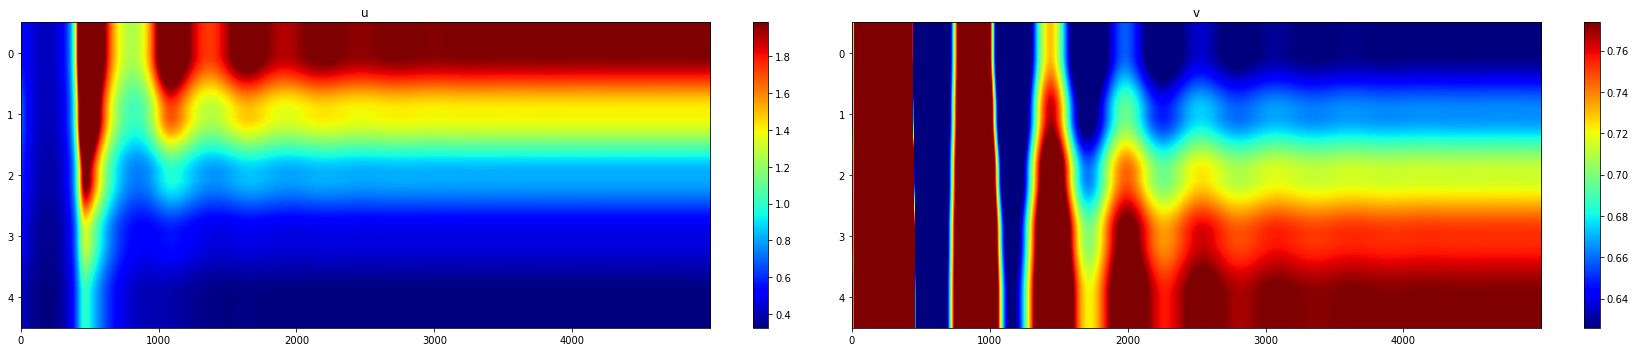

<Figure size 432x288 with 0 Axes>

In [16]:
gt = GroundTruthTuring(50, 5000)
gt.print()

In [20]:
class GroundTruthTuring:
  def __init__(self, t_max, length):
    np.random.seed(0)
    self.config = ConfigTuring()
    param_keys = ["NN", "MM", "l", "w", "c1", "c2", "c_1", "c3", "d1", "d2"]
    config_tuple = tuple(self.config.__dict__.get(one_key) for one_key in param_keys)

    # u_0 = np.random.rand(self.config.NN, self.config.MM) + 2
    # v_0 = np.random.rand(self.config.NN, self.config.MM) + 2
    u_0 = self.config.u_0
    v_0 = self.config.v_0

    y0 = np.concatenate([u_0.flatten(), v_0.flatten()])
    self.t = np.linspace(0, t_max, length)
    # print(self.t)
    sol = odeint(self.pend, y0, self.t, args=config_tuple)
    # print(sol.shape)
    self.u = sol[:, :self.config.NN * self.config.MM]
    self.u_map = self.u.swapaxes(0, 1)
    self.v = sol[:, self.config.NN * self.config.MM:]
    self.v_map = self.v.swapaxes(0, 1)
    print("truth shape: u: {}, v: {}".format(self.u.shape, self.v.shape))
  
  ## @staticmethod
  # def get_diffusion(maps, N, M, l, w, c1, c2, c_1, c3, d1, d2):
  #   u_input, v_input = maps[0], maps[1]
  #   # print("u_input:", u_input)
  #   # u_from_left = np.roll(u_input, 1, axis=1)
  #   # u_from_left[:, :1] = u_input[:, :1]
  #   # u_from_right = np.roll(u_input, -1, axis=1)
  #   # u_from_right[:, -1:] = u_input[:, -1:]
  #   u_from_top = np.roll(u_input, 1, axis=0)
  #   u_from_top[:1, :] = u_input[:1, :]
  #   u_from_bottom = np.roll(u_input, -1, axis=0)
  #   u_from_bottom[-1:, :] = u_input[-1:, :]
  #   # v_from_left = np.roll(v_input, 1, axis=1)
  #   # v_from_left[:, :1] = v_input[:, :1]
  #   # v_from_right = np.roll(v_input, -1, axis=1)
  #   # v_from_right[:, -1:] = v_input[:, -1:]
  #   v_from_top = np.roll(v_input, 1, axis=0)
  #   v_from_top[:1, :] = v_input[:1, :]
  #   v_from_bottom = np.roll(v_input, -1, axis=0)
  #   v_from_bottom[-1:, :] = v_input[-1:, :]
  #   u_diffusion = ((u_from_top + u_from_bottom - u_input * 2) / (w ** 2) ) * d1  # ((u_from_left + u_from_right - u_input * 2) / (l ** 2) + (u_from_top + u_from_bottom - u_input * 2) / (w ** 2)) * d1
  #   v_diffusion = ((v_from_top + v_from_bottom - v_input * 2) / (w ** 2) ) * d2  # ((v_from_left + v_from_right - v_input * 2) / (l ** 2) + (v_from_top + v_from_bottom - v_input * 2) / (w ** 2)) * d2
  #   return np.asarray([u_diffusion, v_diffusion])
  
  def pend(self, y, t, N, M, l, w, c1, c2, c_1, c3, d1, d2):
    # # print(N, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s)
    # u, v = y[:N * M].reshape([N, M]), y[N * M:].reshape([N, M])
    # maps = np.asarray([u, v])
    # d_reaction = np.asarray([
    #                         c1 - c_1 * u + c3 * (u ** 2) * v,  # u * (alpha - beta * u - q / (u + b)) - c * u * v / (m * v + 1) + 1e-4/(u*v),#0.05*(u-0.2) * (v-1.3) ,
    #                         c2 - c3 * (u ** 2) * v# v * (-gamma + s * u / (m * v + 1)) - c * u * v / (m * u + 1) + 1e-4/(u*v)
    # ])#- 0.05*(u-0.2) * (v-1.3) ])

    # # d_reaction = np.asarray([4
    # #                         u * (alpha - beta * u - q / (u + b)) - c * u * v / (m * v + 1),
    # #                         v * (-gamma + s * u / (m * v + 1))  
    # # ])#- 0.05*(u-0.2) * (v-1.3) ])
    # d_diffusion = self.get_diffusion(maps, N, M, l, w, c1, c2, c_1, c3, d1, d2)
    # dydt = d_reaction + d_diffusion
    # # print(d_diffusion.shape)
    # dydt_old = np.concatenate([dydt[0].flatten(), dydt[1].flatten()])
    # # print(N, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s)
    u, v = torch.tensor(y[:N].reshape([1, N]), dtype=torch.float64), torch.tensor(y[N:].reshape([1, N]), dtype=torch.float64)
    u_reaction = c1 - c_1 * u + c3 * (u * u) * v
    v_reaction = c2 - c3 * (u * u) * v

    u_from_left = torch.roll(u, 1, 1)
    u_from_left[:, :1] = u[:, :1]
    u_from_right = torch.roll(u, -1, 1)
    u_from_right[:, -1:] = u[:, -1:]

    v_from_left = torch.roll(v, 1, 1)
    v_from_left[:, :1] = v[:, :1]
    v_from_right = torch.roll(v, -1, 1)
    v_from_right[:, -1:] = v[:, -1:]

    u_diffusion = self.config.d1 * ((u_from_left + u_from_right - u * 2) / (self.config.l ** 2))
    v_diffusion = self.config.d2 * ((v_from_left + v_from_right - v * 2) / (self.config.l ** 2))
    # print("u_diffusion:", u_diffusion.shape)
    # print("v_diffusion:", v_diffusion.shape)
    du = u_diffusion + u_reaction
    dv = v_diffusion + v_reaction

    # dydt = d_reaction + d_diffusion
    # print(d_diffusion.shape)
    dydt_new = np.concatenate([du.cpu().detach().numpy().flatten(), dv.cpu().detach().numpy().flatten()])
    # print("dydt_old:", dydt_old)
    # print("dydt_new:", dydt_new)
    return dydt_new

  def print(self):
    draw_turing(self.u_map, self.v_map, self.config)


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def draw_turing(u, v, config, save_flag=False, save_path=None):

    fig = plt.figure(figsize=(24, 5))

    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(u, cmap=plt.cm.jet, vmin=u[:,-1:].min(), vmax=u[:,-1:].max(), aspect='auto')
    ax1.set_title("u")
    cb1 = plt.colorbar(im1, shrink=1)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(v, cmap=plt.cm.jet, vmin=v[:,-1:].min(), vmax=v[:,-1:].max(), aspect='auto')
    ax2.set_title("v")
    cb2 = plt.colorbar(im2, shrink=1)
    plt.tight_layout()
    if save_flag:
        plt.savefig(save_path, dpi=300)
    plt.show()
    plt.clf()

def train_turing(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)

    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = np.inf
    loss_record = []
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        if config.only_truth_flag:
            loss, loss_list = model.loss_only_ground_truth()
        else:
            loss, loss_list, _ = model.loss()
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_turing(model, args, config, now_string, True)
            draw_loss(np.asarray(loss_record))
            np.save(loss_save_path, np.asarray(loss_record))

def test_turing(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    u, v = y[:, :model.config.NN * model.config.MM], y[:, model.config.NN * model.config.MM:]
    u = u.cpu().detach().numpy().swapaxes(0, 1)
    v = v.cpu().detach().numpy().swapaxes(0, 1)
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    print("Truth:")
    draw_turing(model.gt.u_map, model.gt.v_map, model.config, False, None)
    print("Pred:")
    draw_turing(u, v, model.config, True, figure_save_path)
    print("Diff:")
    draw_turing(model.gt.u_map - u, model.gt.v_map - v, model.config, False, None)


class Args:
  epoch = 100000
  epoch_step = 100
  lr = 0.001
  main_path = "."
  save_step = 500

def draw_loss(loss_list):
    draw_two_dimension(
        y_lists=[loss_list],
        x_list=range(1, len(loss_list) + 1),
        color_list=["blue"],
        legend_list=["loss"],
        line_style_list=["solid"],
        fig_title="Loss - {} epochs".format(len(loss_list)),
        fig_x_label="epoch",
        fig_y_label="loss",
        fig_size=(8, 6),
        show_flag=True,
        save_flag=False,
        save_path=None
    )

def run_turing(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigTuring()
    model = SimpleNetworkTuring(config).to(device)
    train_turing(model, args, config, now_string)
    # model = SimpleNetworkTuring(config).to(device)
    # test_turing(model, args, config, now_string)

self.truth_length: 5000 of 5000 all 
truth shape: u: (5000, 5), v: (5000, 5)
using cuda
epoch = 100000
epoch_step = 100
model_name = SimpleNetworkTuring
now_string = 2022-06-18-06-36-39
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_100000_100_0.001_2022-06-18-06-36-39_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_100000_100_0.001_2022-06-18-06-36-39_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkTuring_100000_100_0.001_2022-06-18-06-36-39_loss_100000.npy
Epoch [00100/100000] Loss:30.961241 Loss_1:4.333546 Loss_2:12.234982 Loss_3:12.095764 Loss_4:2.296949 Lr:0.000990 Time:2.524573s (0.04min in total, 42.03min remains)
Epoch [00200/100000] Loss:52.652790 Loss_1:4.040112 Loss_2:30.271111 Loss_3:16.377964 Loss_4:1.963606 Lr:0.000980 Time:2.506053s (0.08min in total, 41.84min remains)
Epoch [00300/100000] Loss:112.177071 Loss_1:4.557207 Loss_2:93.779007 Loss_3:11.20

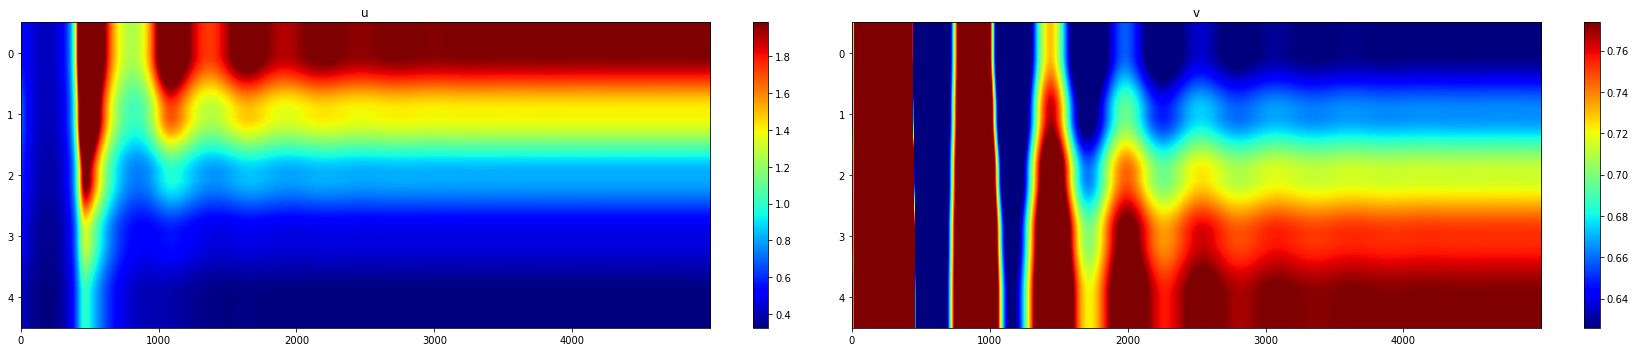

Pred:


<Figure size 432x288 with 0 Axes>

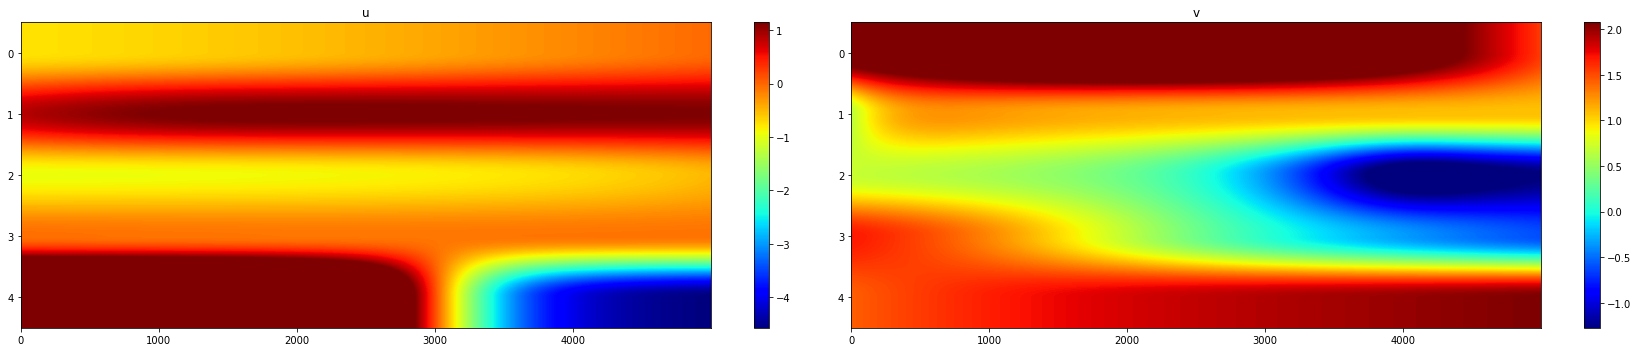

Diff:


<Figure size 432x288 with 0 Axes>

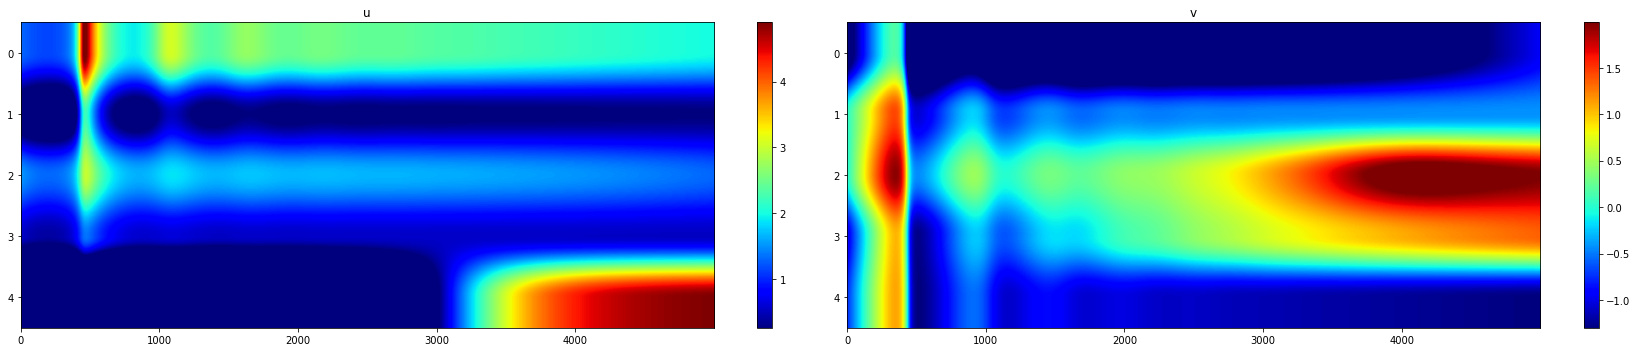

<Figure size 432x288 with 0 Axes>

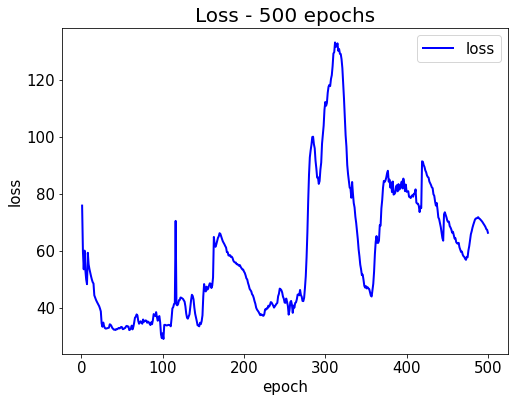

Epoch [00600/100000] Loss:47.414307 Loss_1:3.192890 Loss_2:33.514687 Loss_3:9.007659 Loss_4:1.699069 Lr:0.000943 Time:7.291708s (0.33min in total, 54.96min remains)
Epoch [00700/100000] Loss:53.982754 Loss_1:2.700979 Loss_2:39.229340 Loss_3:10.638602 Loss_4:1.413830 Lr:0.000935 Time:2.581429s (0.37min in total, 53.17min remains)
Epoch [00800/100000] Loss:42.493038 Loss_1:2.155191 Loss_2:27.960005 Loss_3:11.343451 Loss_4:1.034388 Lr:0.000926 Time:2.573612s (0.42min in total, 51.79min remains)
Epoch [00900/100000] Loss:32.544365 Loss_1:2.011225 Loss_2:21.078379 Loss_3:8.588209 Loss_4:0.866553 Lr:0.000917 Time:2.571960s (0.46min in total, 50.71min remains)
Epoch [01000/100000] Loss:32.405373 Loss_1:2.050436 Loss_2:20.529930 Loss_3:8.962802 Loss_4:0.862205 Lr:0.000909 Time:2.494868s (0.50min in total, 49.71min remains)
Testing & drawing...
Truth:


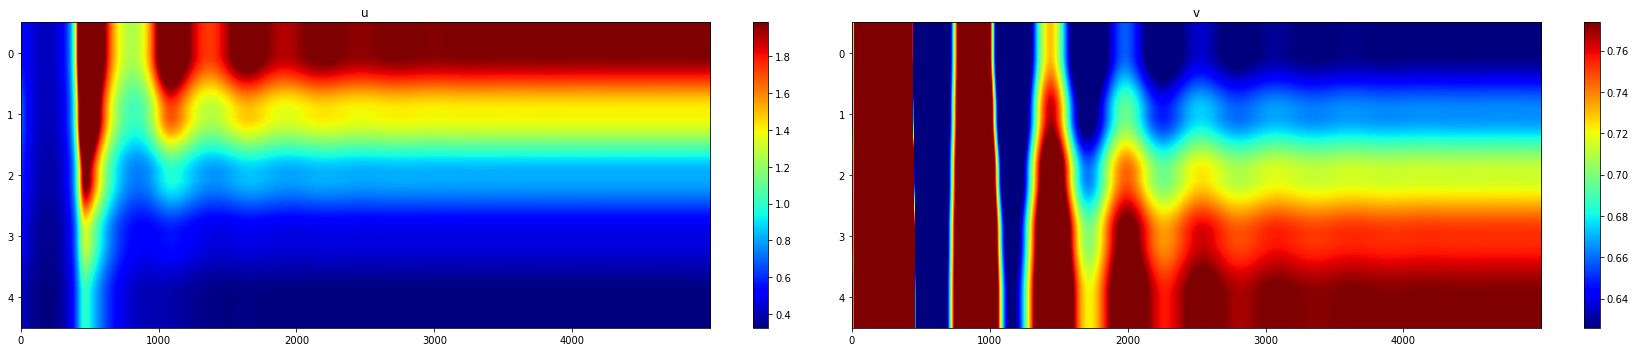

Pred:


<Figure size 432x288 with 0 Axes>

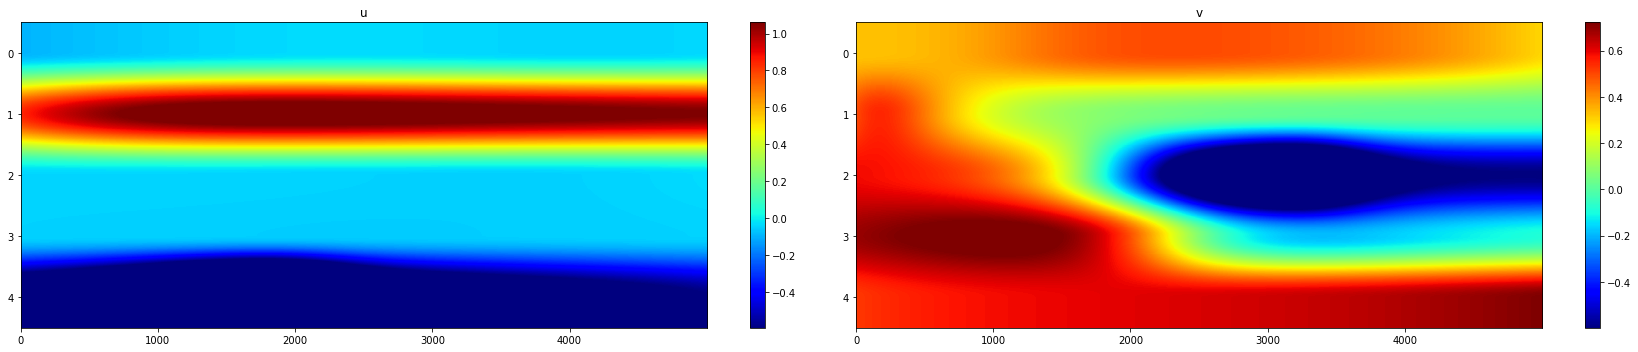

Diff:


<Figure size 432x288 with 0 Axes>

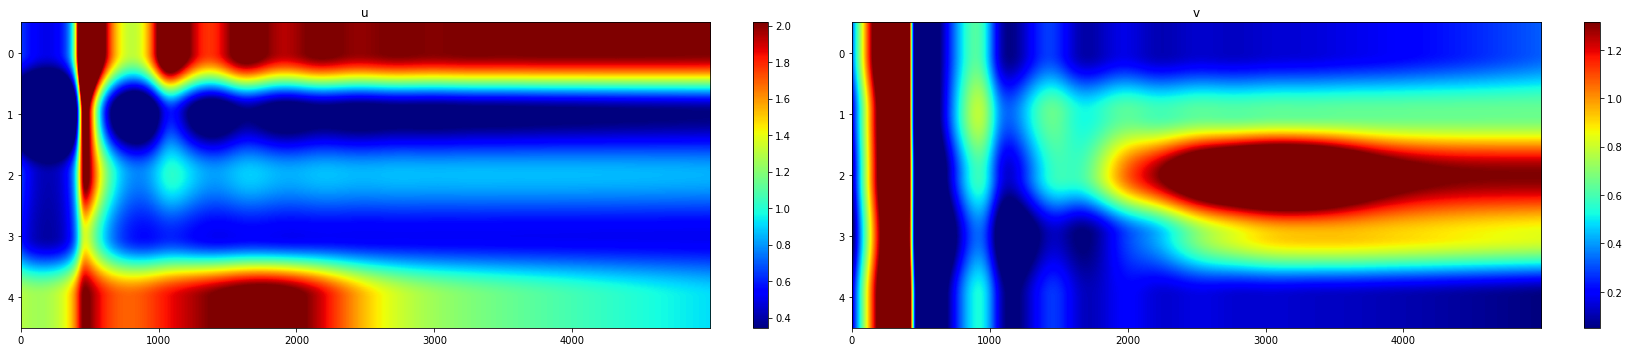

<Figure size 432x288 with 0 Axes>

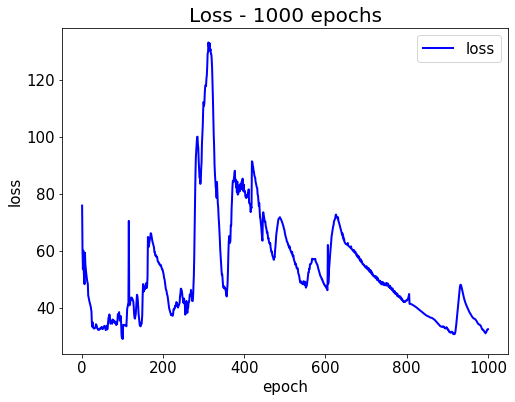

Epoch [01100/100000] Loss:62.654522 Loss_1:2.237859 Loss_2:51.841457 Loss_3:7.596124 Loss_4:0.979086 Lr:0.000901 Time:7.553405s (0.63min in total, 56.47min remains)
Epoch [01200/100000] Loss:32.139256 Loss_1:1.950272 Loss_2:21.860538 Loss_3:7.606767 Loss_4:0.721677 Lr:0.000893 Time:2.753591s (0.67min in total, 55.49min remains)
Epoch [01300/100000] Loss:22.390038 Loss_1:1.881483 Loss_2:12.655839 Loss_3:7.197429 Loss_4:0.655287 Lr:0.000885 Time:2.516831s (0.72min in total, 54.35min remains)
Epoch [01400/100000] Loss:18.272896 Loss_1:1.906478 Loss_2:8.504801 Loss_3:7.248525 Loss_4:0.613093 Lr:0.000877 Time:2.482776s (0.76min in total, 53.33min remains)
Epoch [01500/100000] Loss:15.798584 Loss_1:1.926903 Loss_2:6.249750 Loss_3:7.044309 Loss_4:0.577622 Lr:0.000870 Time:2.509935s (0.80min in total, 52.47min remains)
Testing & drawing...
Truth:


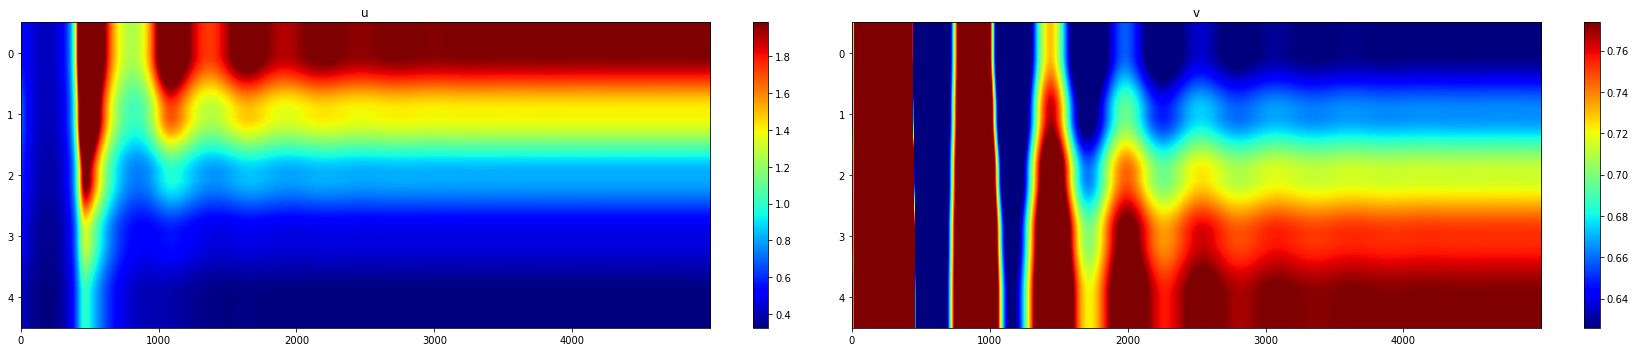

Pred:


<Figure size 432x288 with 0 Axes>

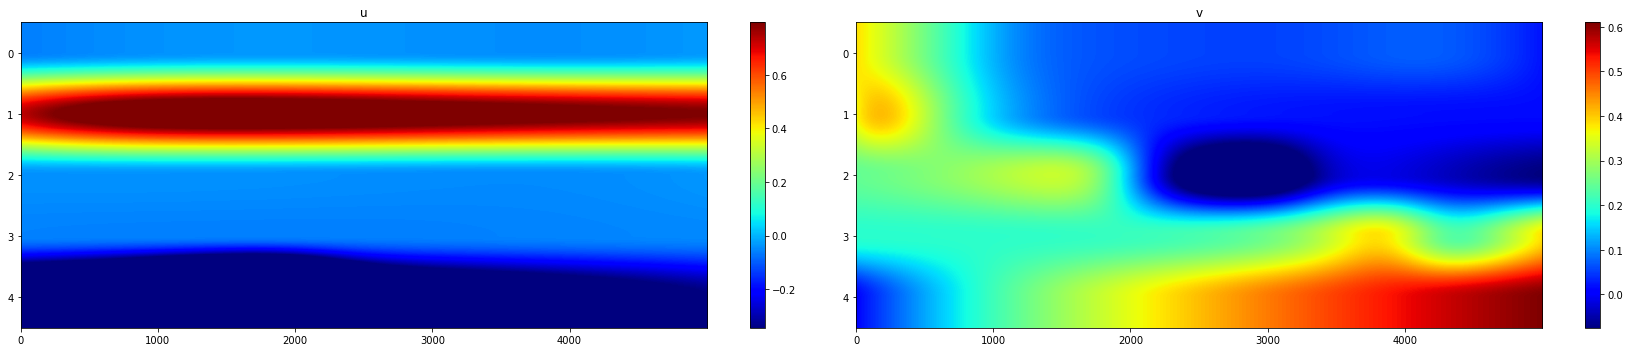

Diff:


<Figure size 432x288 with 0 Axes>

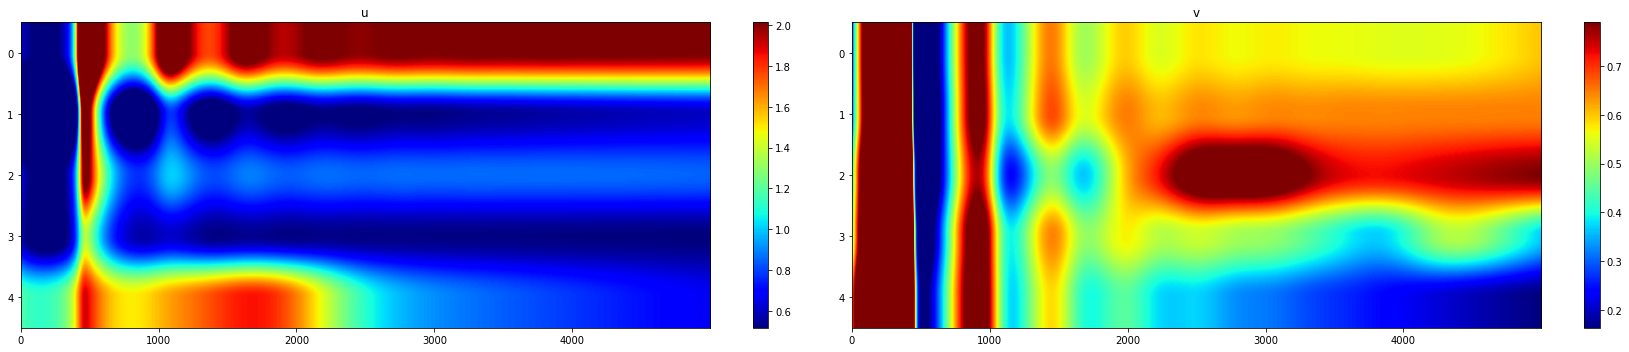

<Figure size 432x288 with 0 Axes>

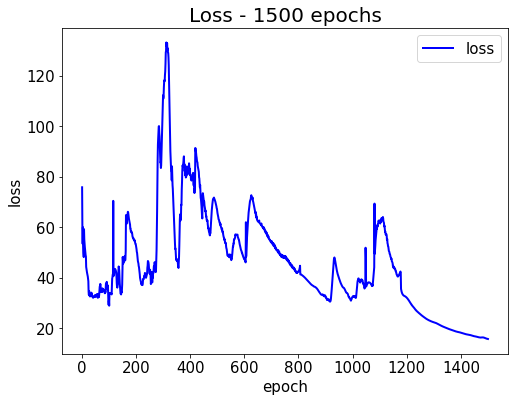

Epoch [01600/100000] Loss:13.559104 Loss_1:1.968574 Loss_2:4.413959 Loss_3:6.630502 Loss_4:0.546069 Lr:0.000862 Time:7.335924s (0.92min in total, 56.66min remains)
Epoch [01700/100000] Loss:44.688904 Loss_1:2.293428 Loss_2:41.333351 Loss_3:0.146629 Loss_4:0.915498 Lr:0.000855 Time:2.518286s (0.96min in total, 55.70min remains)
Epoch [01800/100000] Loss:20.760075 Loss_1:2.057770 Loss_2:17.676868 Loss_3:0.410776 Loss_4:0.614660 Lr:0.000847 Time:2.540685s (1.01min in total, 54.87min remains)
Epoch [01900/100000] Loss:7.848001 Loss_1:2.017863 Loss_2:4.770467 Loss_3:0.580627 Loss_4:0.479044 Lr:0.000840 Time:2.541737s (1.05min in total, 54.11min remains)
Epoch [02000/100000] Loss:5.603909 Loss_1:2.052745 Loss_2:2.460593 Loss_3:0.644896 Loss_4:0.445674 Lr:0.000833 Time:2.504201s (1.09min in total, 53.40min remains)
Testing & drawing...
Truth:


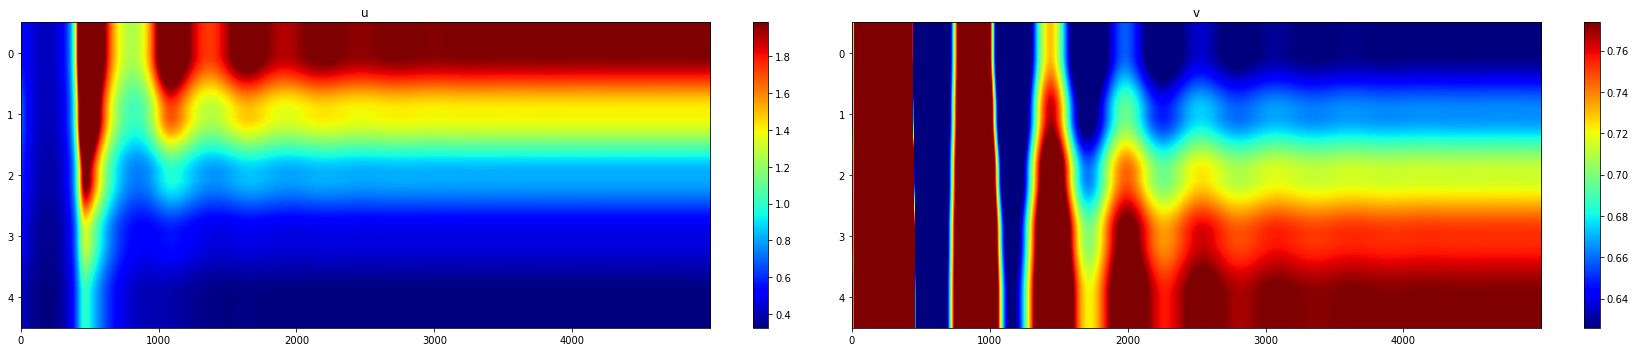

Pred:


<Figure size 432x288 with 0 Axes>

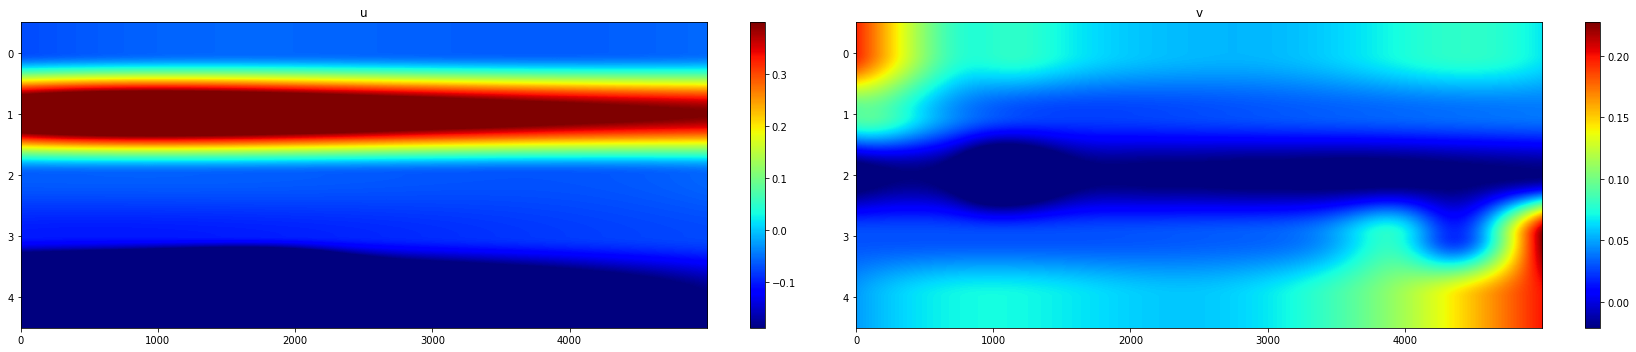

Diff:


<Figure size 432x288 with 0 Axes>

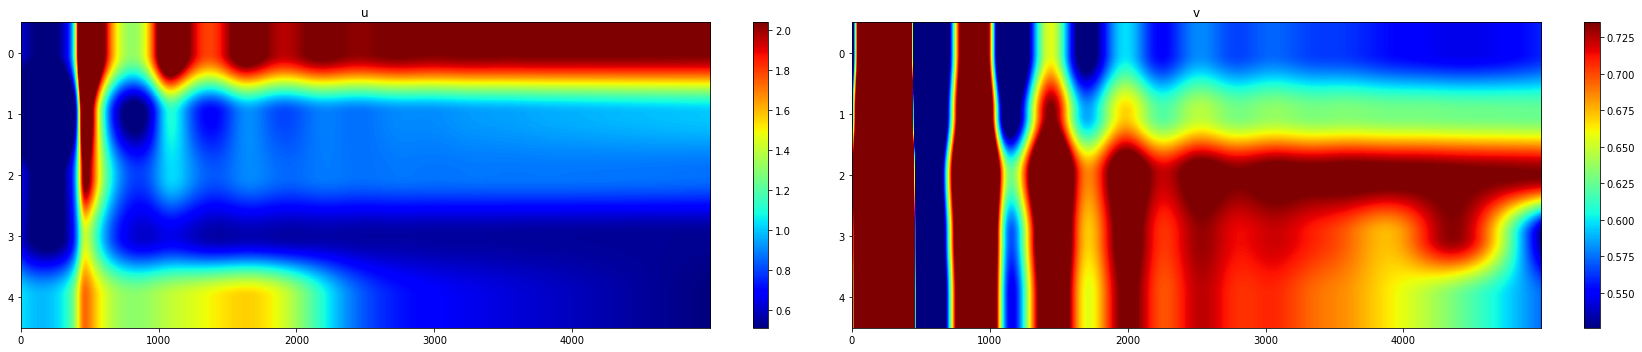

<Figure size 432x288 with 0 Axes>

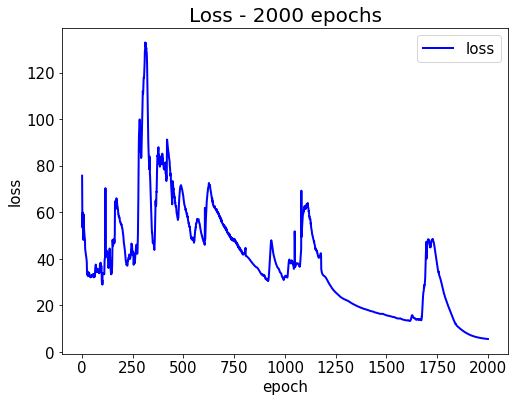

Epoch [02100/100000] Loss:5.305062 Loss_1:2.075949 Loss_2:2.148453 Loss_3:0.663630 Loss_4:0.417029 Lr:0.000826 Time:7.297750s (1.21min in total, 56.48min remains)
Epoch [02200/100000] Loss:5.155499 Loss_1:2.078010 Loss_2:2.006393 Loss_3:0.682274 Loss_4:0.388822 Lr:0.000820 Time:2.536588s (1.25min in total, 55.73min remains)
Epoch [02300/100000] Loss:5.055525 Loss_1:2.074447 Loss_2:1.926450 Loss_3:0.693403 Loss_4:0.361224 Lr:0.000813 Time:2.531829s (1.30min in total, 55.05min remains)
Epoch [02400/100000] Loss:4.978262 Loss_1:2.069826 Loss_2:1.872857 Loss_3:0.701315 Loss_4:0.334264 Lr:0.000806 Time:2.484336s (1.34min in total, 54.38min remains)
Epoch [02500/100000] Loss:4.915559 Loss_1:2.064962 Loss_2:1.835365 Loss_3:0.707354 Loss_4:0.307878 Lr:0.000800 Time:2.536707s (1.38min in total, 53.80min remains)
Testing & drawing...
Truth:


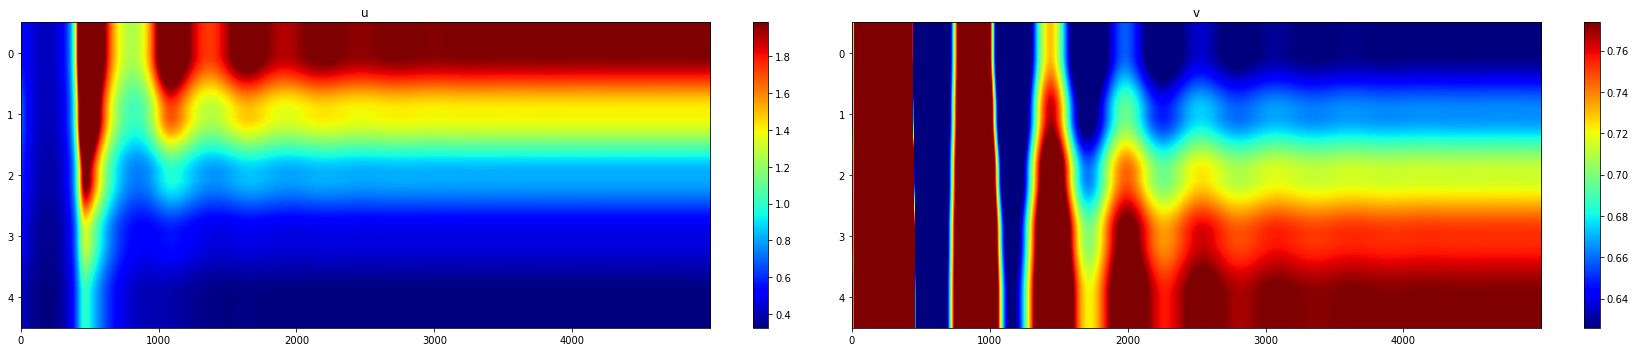

Pred:


<Figure size 432x288 with 0 Axes>

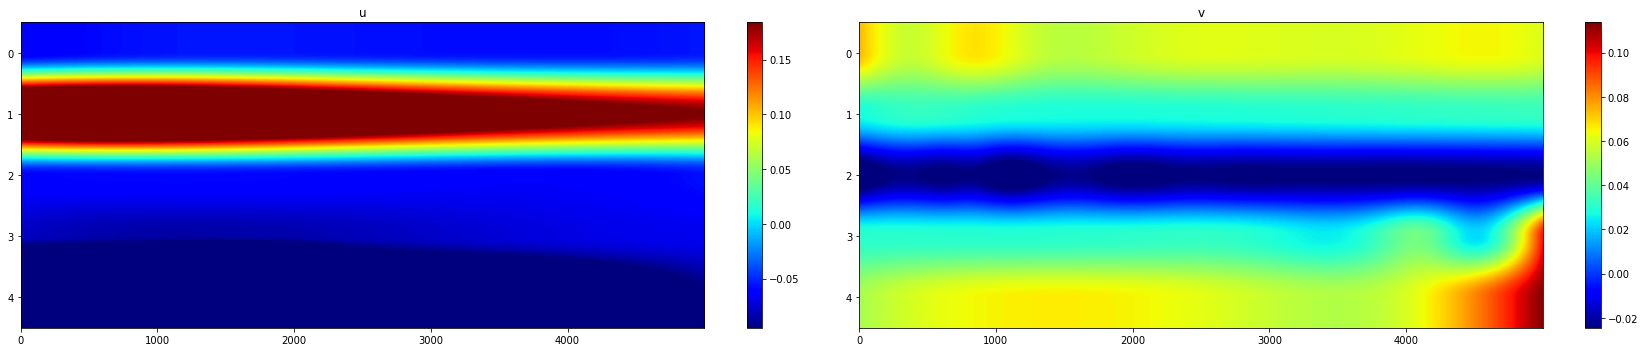

Diff:


<Figure size 432x288 with 0 Axes>

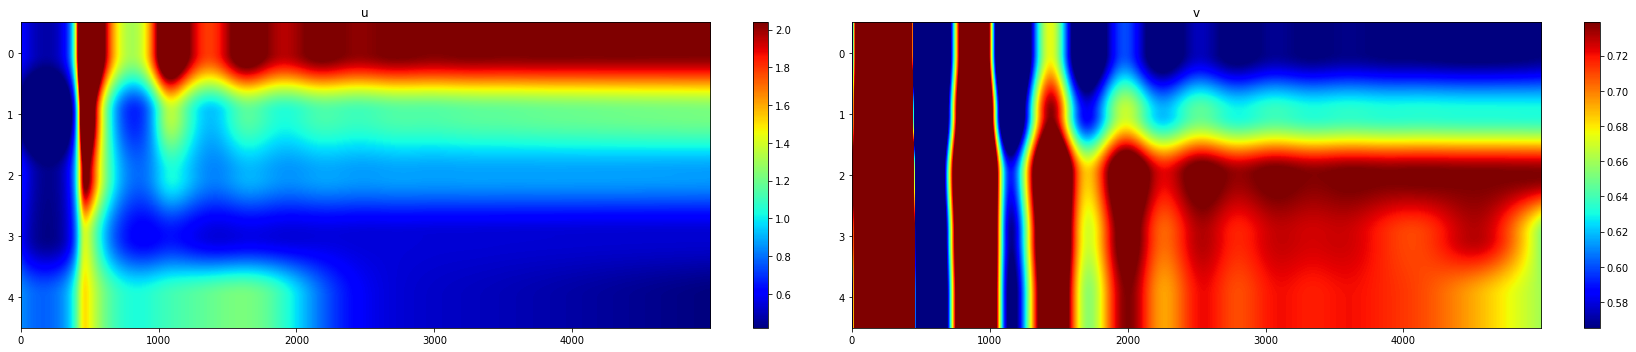

<Figure size 432x288 with 0 Axes>

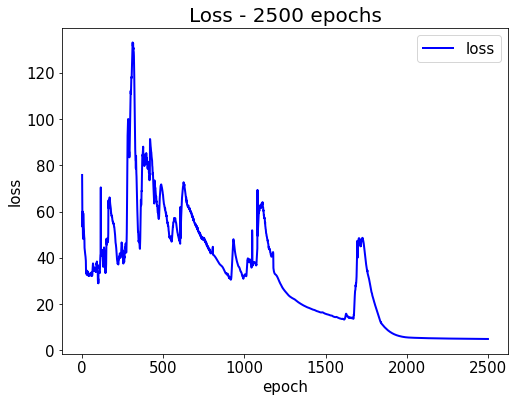

Epoch [02600/100000] Loss:4.862793 Loss_1:2.060054 Loss_2:1.808634 Loss_3:0.712131 Loss_4:0.281974 Lr:0.000794 Time:7.284667s (1.50min in total, 56.23min remains)
Epoch [02700/100000] Loss:4.816752 Loss_1:2.055201 Loss_2:1.789043 Loss_3:0.716064 Loss_4:0.256445 Lr:0.000787 Time:2.486185s (1.54min in total, 55.59min remains)
Epoch [02800/100000] Loss:4.775312 Loss_1:2.050462 Loss_2:1.774204 Loss_3:0.719453 Loss_4:0.231194 Lr:0.000781 Time:2.502906s (1.58min in total, 54.99min remains)
Epoch [02900/100000] Loss:4.737153 Loss_1:2.045865 Loss_2:1.762605 Loss_3:0.722521 Loss_4:0.206162 Lr:0.000775 Time:2.475626s (1.63min in total, 54.42min remains)
Epoch [03000/100000] Loss:4.701563 Loss_1:2.041423 Loss_2:1.753304 Loss_3:0.725453 Loss_4:0.181384 Lr:0.000769 Time:2.502632s (1.67min in total, 53.91min remains)
Testing & drawing...
Truth:


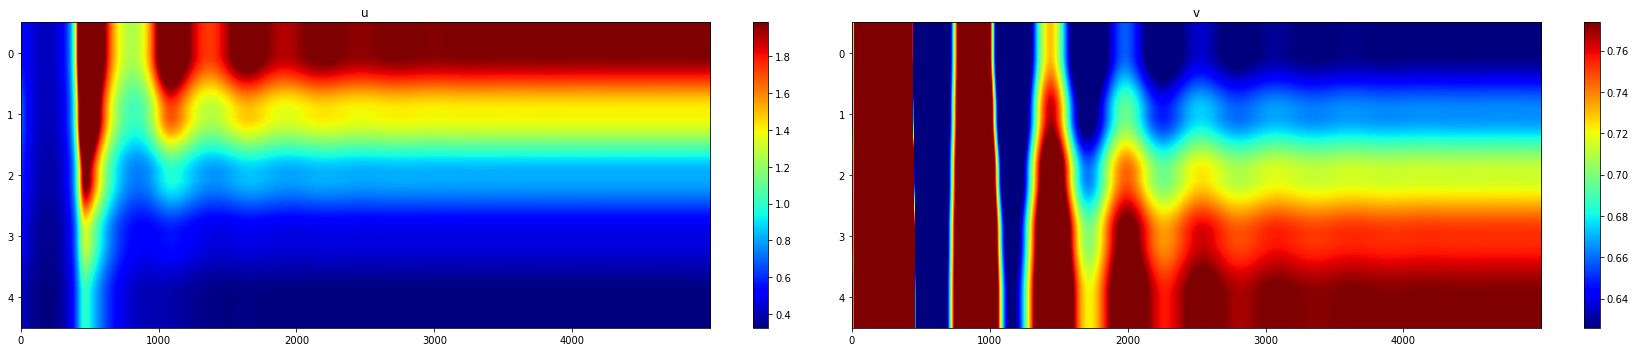

Pred:


<Figure size 432x288 with 0 Axes>

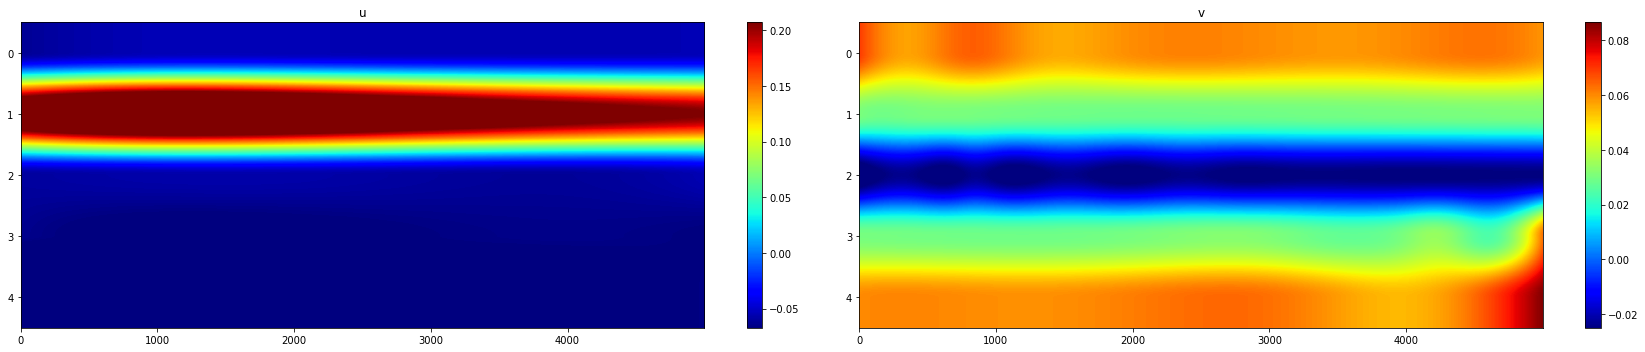

Diff:


<Figure size 432x288 with 0 Axes>

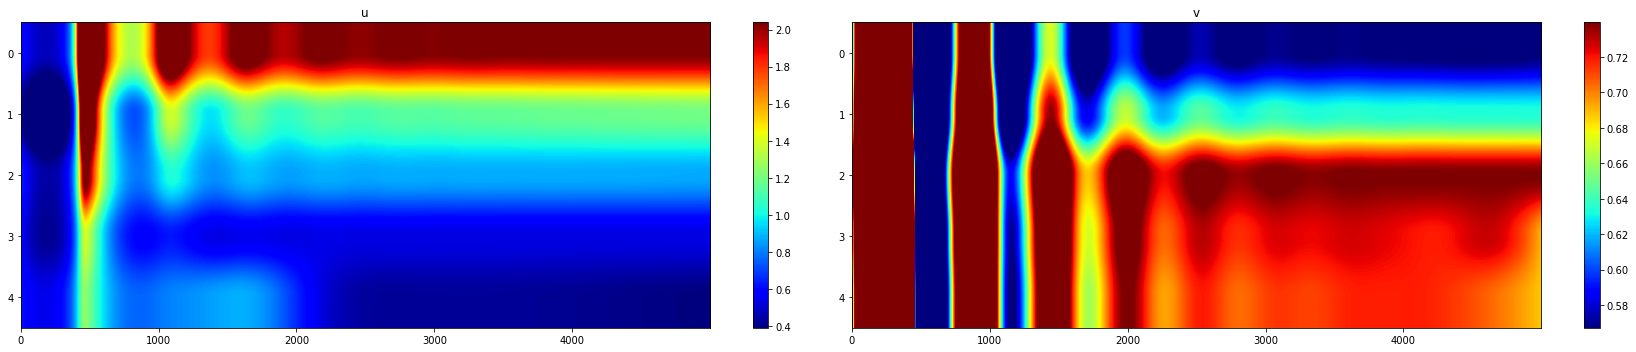

<Figure size 432x288 with 0 Axes>

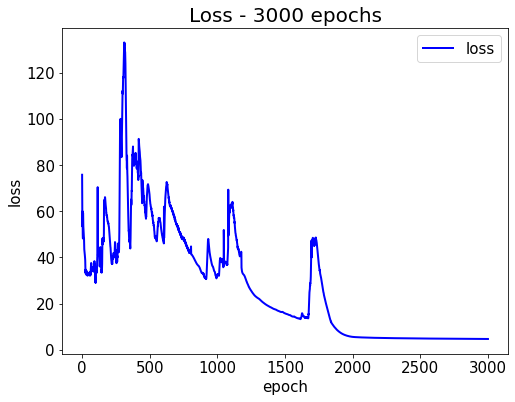

Epoch [03100/100000] Loss:4.668410 Loss_1:2.037163 Loss_2:1.745690 Loss_3:0.728460 Loss_4:0.157097 Lr:0.000763 Time:7.354178s (1.79min in total, 55.94min remains)
Epoch [03200/100000] Loss:4.638420 Loss_1:2.033174 Loss_2:1.739334 Loss_3:0.731873 Loss_4:0.134040 Lr:0.000758 Time:2.505398s (1.83min in total, 55.40min remains)
Epoch [03300/100000] Loss:4.614434 Loss_1:2.029782 Loss_2:1.733814 Loss_3:0.736464 Loss_4:0.114374 Lr:0.000752 Time:2.495916s (1.87min in total, 54.89min remains)
Epoch [03400/100000] Loss:4.604332 Loss_1:2.028042 Loss_2:1.728772 Loss_3:0.743425 Loss_4:0.104094 Lr:0.000746 Time:2.569417s (1.92min in total, 54.43min remains)
Epoch [03500/100000] Loss:4.598274 Loss_1:2.027431 Loss_2:1.726707 Loss_3:0.744486 Loss_4:0.099650 Lr:0.000741 Time:2.503496s (1.96min in total, 53.98min remains)
Testing & drawing...
Truth:


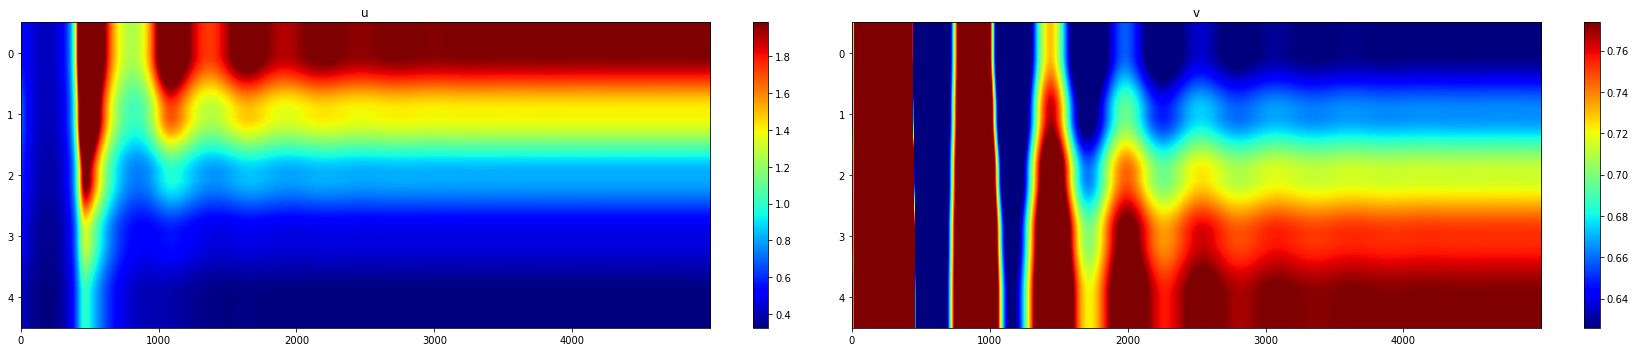

Pred:


<Figure size 432x288 with 0 Axes>

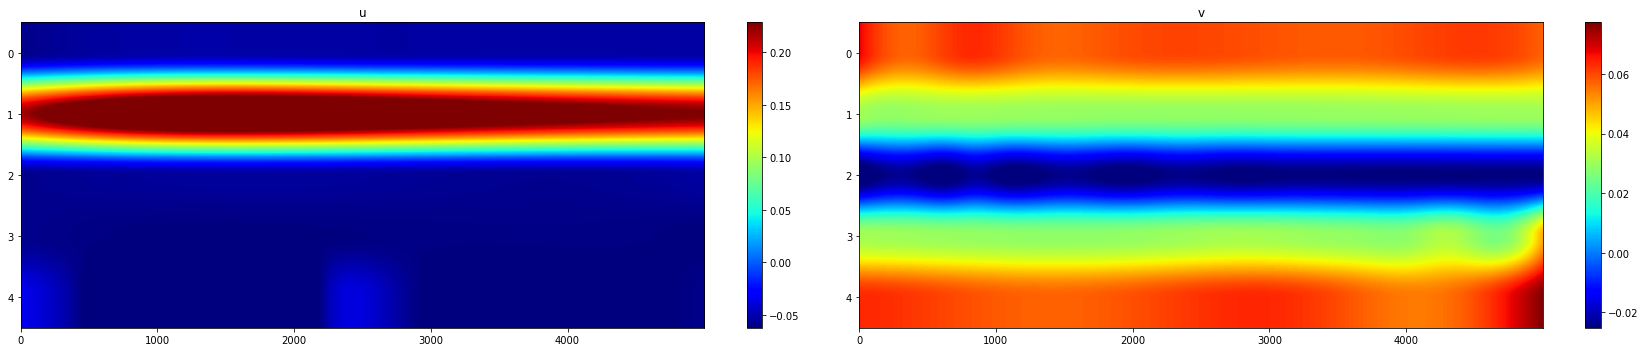

Diff:


<Figure size 432x288 with 0 Axes>

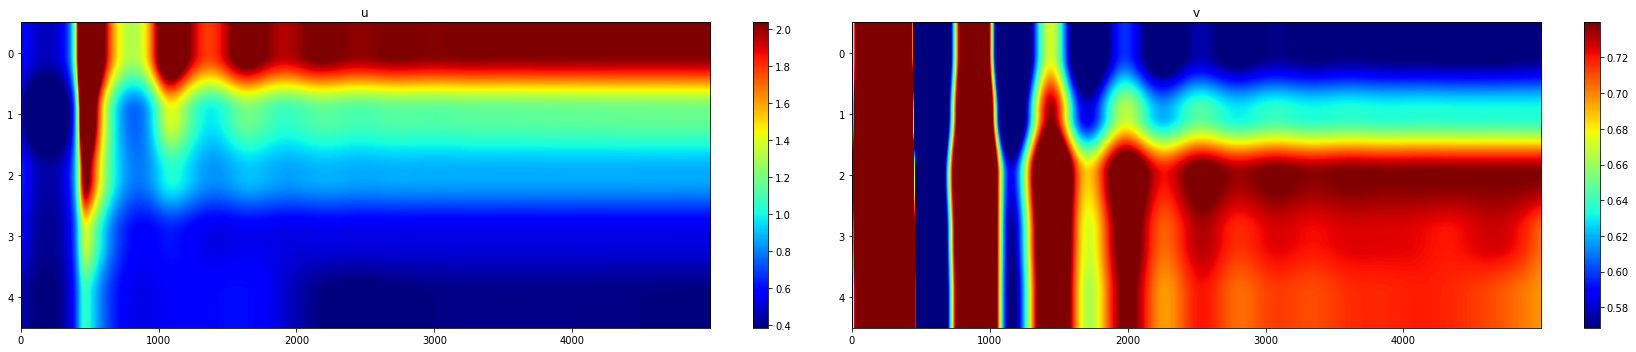

<Figure size 432x288 with 0 Axes>

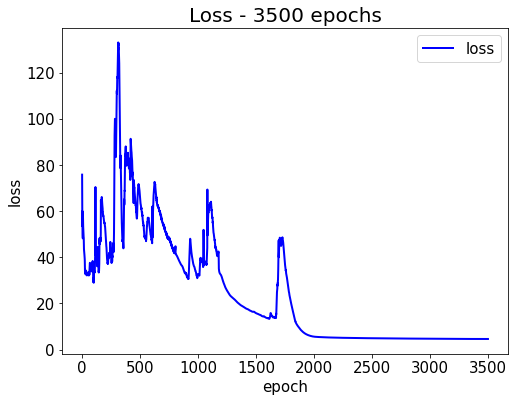

Epoch [03600/100000] Loss:4.592806 Loss_1:2.026856 Loss_2:1.724913 Loss_3:0.745555 Loss_4:0.095482 Lr:0.000735 Time:7.318507s (2.08min in total, 55.69min remains)
Epoch [03700/100000] Loss:4.587882 Loss_1:2.026333 Loss_2:1.723377 Loss_3:0.746495 Loss_4:0.091678 Lr:0.000730 Time:2.484793s (2.12min in total, 55.20min remains)
Epoch [03800/100000] Loss:4.583475 Loss_1:2.025861 Loss_2:1.722058 Loss_3:0.747293 Loss_4:0.088262 Lr:0.000725 Time:2.536908s (2.16min in total, 54.77min remains)
Epoch [03900/100000] Loss:4.579572 Loss_1:2.025441 Loss_2:1.720921 Loss_3:0.747958 Loss_4:0.085252 Lr:0.000719 Time:2.522001s (2.21min in total, 54.34min remains)
Epoch [04000/100000] Loss:4.576176 Loss_1:2.025072 Loss_2:1.719934 Loss_3:0.748510 Loss_4:0.082660 Lr:0.000714 Time:2.500433s (2.25min in total, 53.93min remains)
Testing & drawing...
Truth:


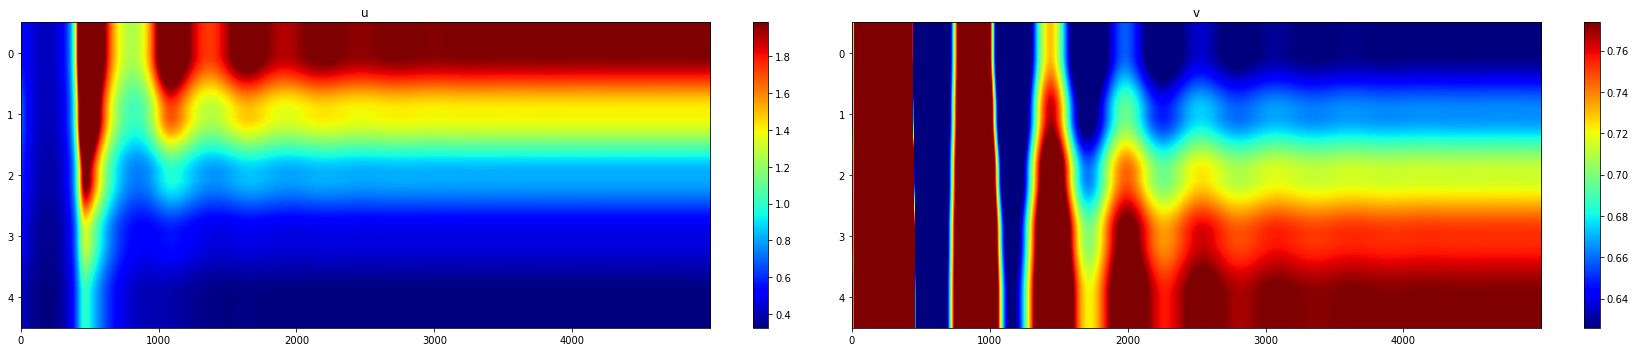

Pred:


<Figure size 432x288 with 0 Axes>

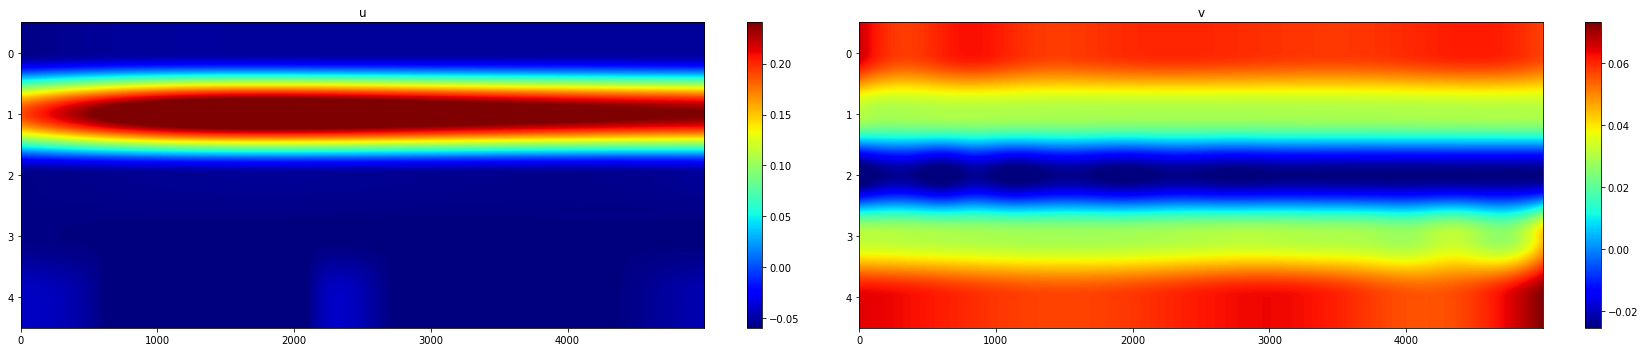

Diff:


<Figure size 432x288 with 0 Axes>

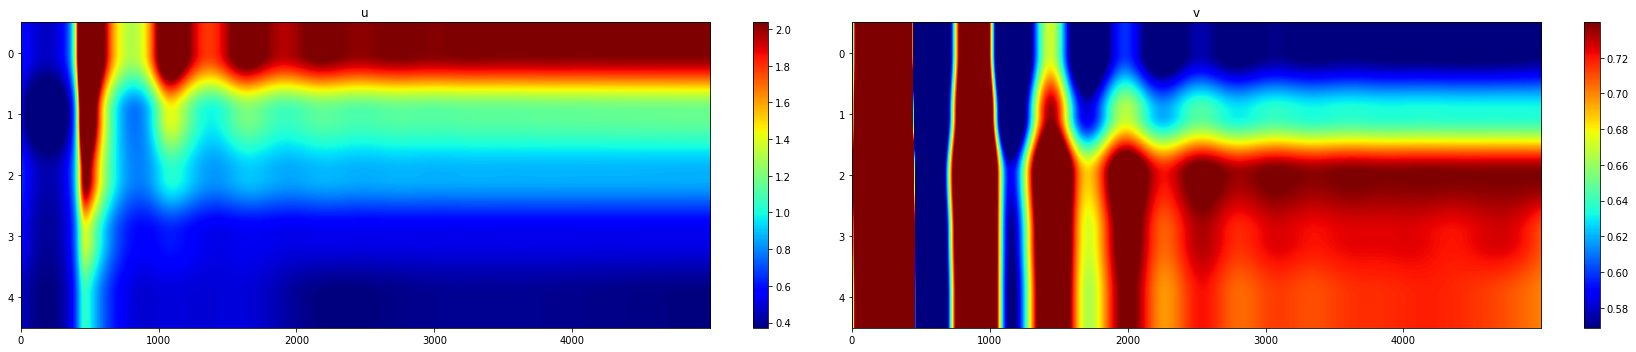

<Figure size 432x288 with 0 Axes>

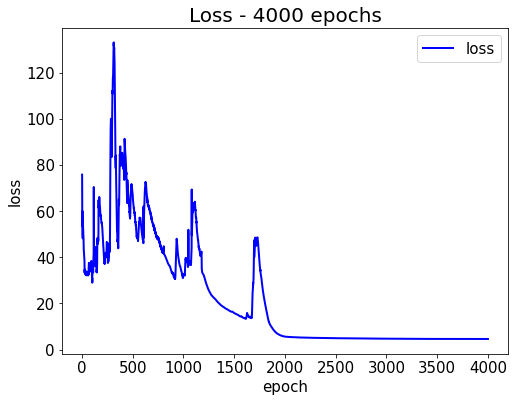

Epoch [04100/100000] Loss:4.573284 Loss_1:2.024756 Loss_2:1.719074 Loss_3:0.748965 Loss_4:0.080488 Lr:0.000709 Time:7.501539s (2.37min in total, 55.48min remains)
Epoch [04200/100000] Loss:4.570879 Loss_1:2.024495 Loss_2:1.718322 Loss_3:0.749339 Loss_4:0.078724 Lr:0.000704 Time:2.588444s (2.42min in total, 55.09min remains)
Epoch [04300/100000] Loss:4.568927 Loss_1:2.024286 Loss_2:1.717663 Loss_3:0.749642 Loss_4:0.077336 Lr:0.000699 Time:2.528019s (2.46min in total, 54.69min remains)
Epoch [04400/100000] Loss:4.567376 Loss_1:2.024128 Loss_2:1.717086 Loss_3:0.749881 Loss_4:0.076281 Lr:0.000694 Time:2.519817s (2.50min in total, 54.30min remains)
Epoch [04500/100000] Loss:4.566159 Loss_1:2.024014 Loss_2:1.716579 Loss_3:0.750064 Loss_4:0.075502 Lr:0.000690 Time:2.539275s (2.54min in total, 53.94min remains)
Testing & drawing...
Truth:


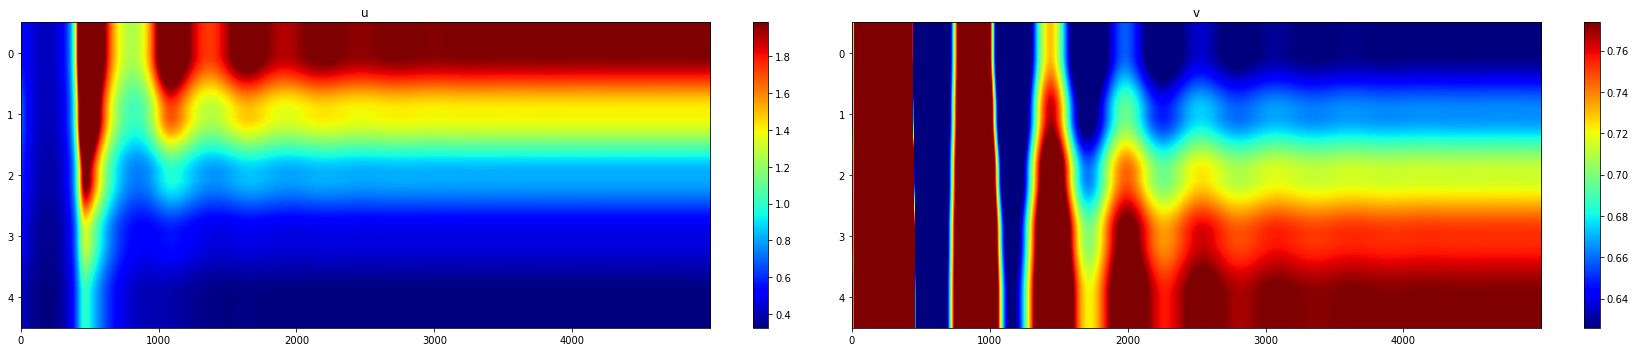

Pred:


<Figure size 432x288 with 0 Axes>

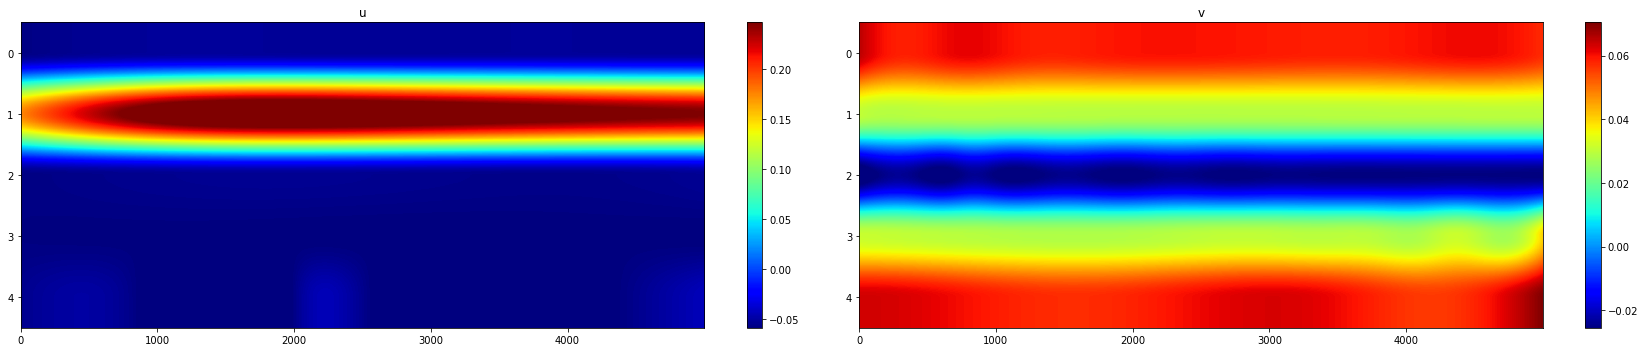

Diff:


<Figure size 432x288 with 0 Axes>

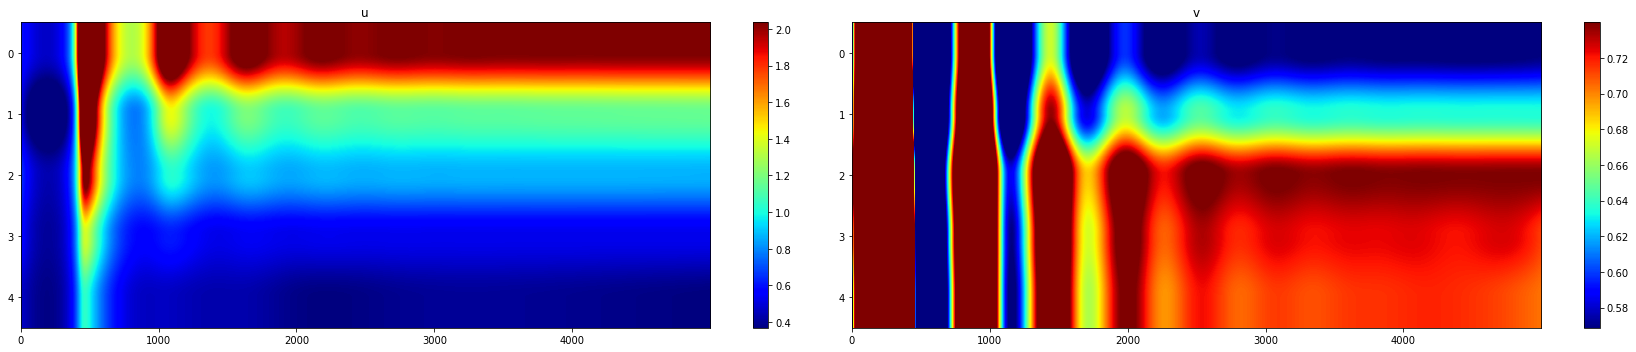

<Figure size 432x288 with 0 Axes>

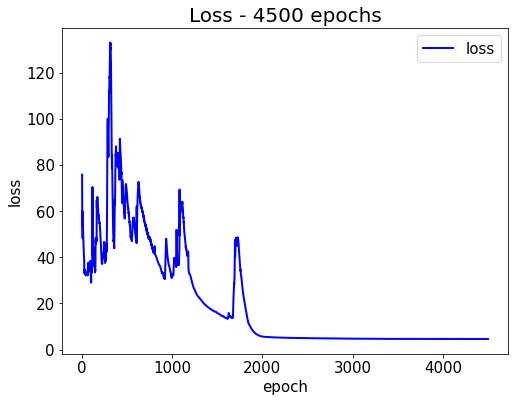

Epoch [04600/100000] Loss:4.565209 Loss_1:2.023935 Loss_2:1.716132 Loss_3:0.750201 Loss_4:0.074941 Lr:0.000685 Time:7.452501s (2.67min in total, 55.29min remains)
Epoch [04700/100000] Loss:4.564462 Loss_1:2.023885 Loss_2:1.715735 Loss_3:0.750302 Loss_4:0.074540 Lr:0.000680 Time:2.560361s (2.71min in total, 54.92min remains)
Epoch [04800/100000] Loss:4.563862 Loss_1:2.023853 Loss_2:1.715379 Loss_3:0.750380 Loss_4:0.074251 Lr:0.000676 Time:2.532152s (2.75min in total, 54.56min remains)
Epoch [04900/100000] Loss:4.563368 Loss_1:2.023833 Loss_2:1.715056 Loss_3:0.750443 Loss_4:0.074036 Lr:0.000671 Time:2.508581s (2.79min in total, 54.20min remains)
Epoch [05000/100000] Loss:4.562948 Loss_1:2.023820 Loss_2:1.714761 Loss_3:0.750499 Loss_4:0.073868 Lr:0.000667 Time:2.478856s (2.83min in total, 53.84min remains)
Testing & drawing...
Truth:


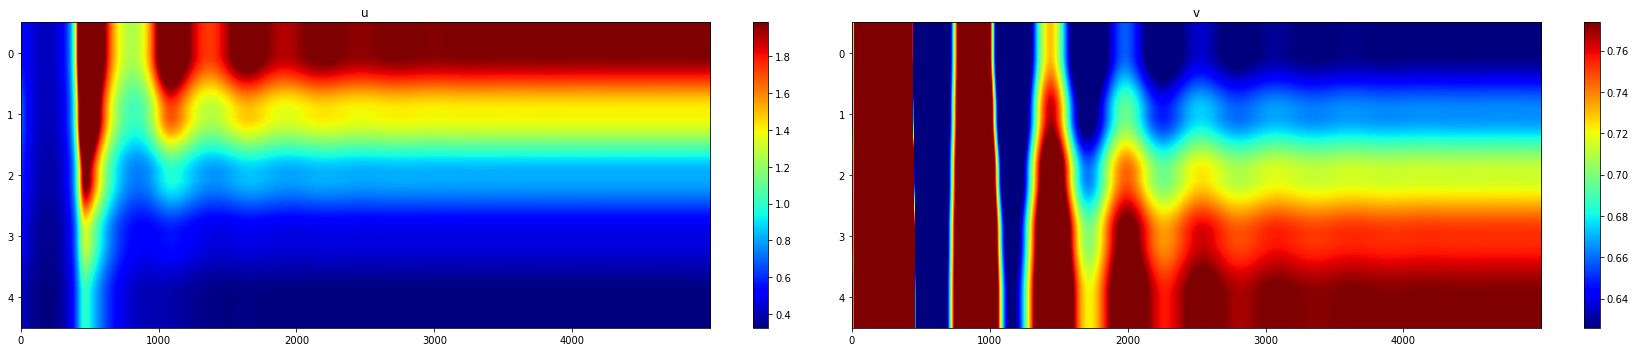

Pred:


<Figure size 432x288 with 0 Axes>

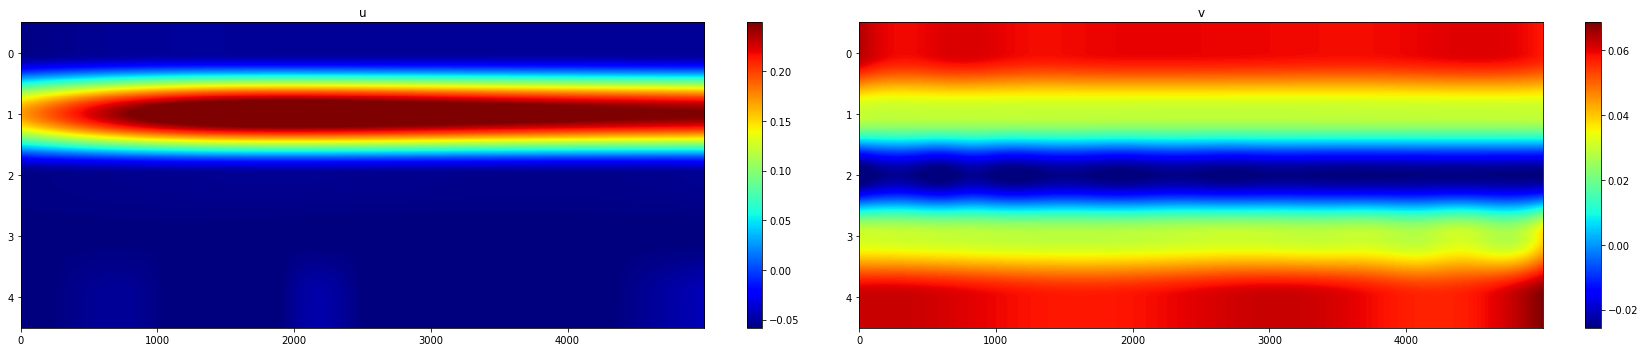

Diff:


<Figure size 432x288 with 0 Axes>

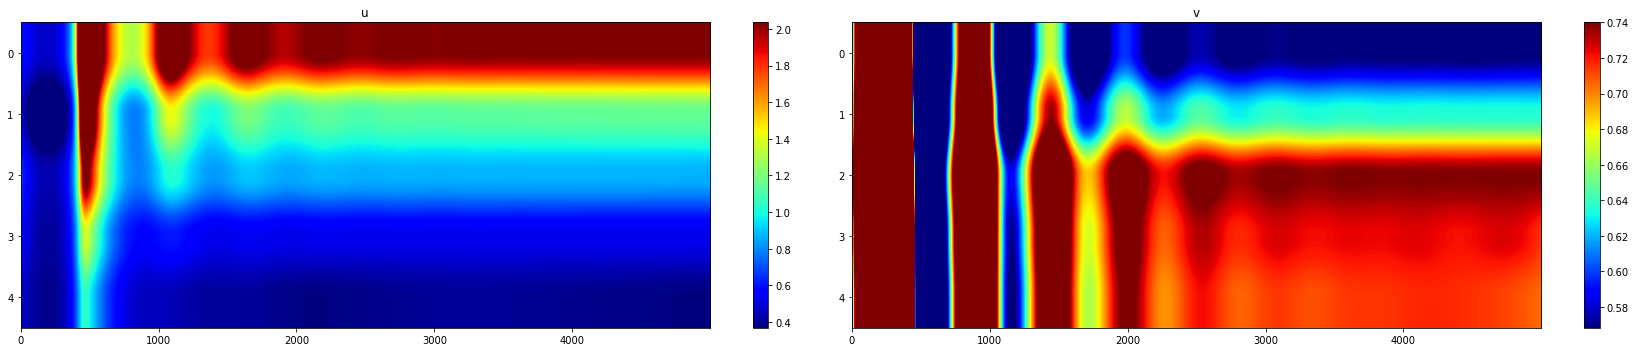

<Figure size 432x288 with 0 Axes>

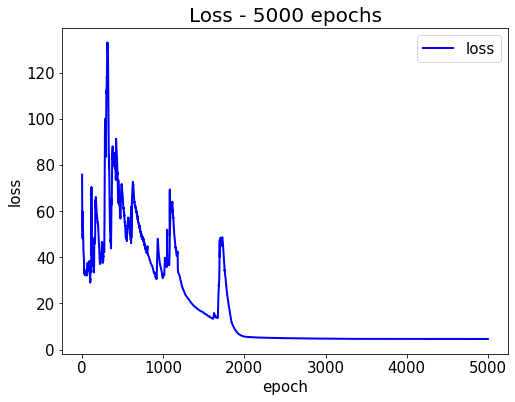

Epoch [05100/100000] Loss:4.562579 Loss_1:2.023810 Loss_2:1.714488 Loss_3:0.750554 Loss_4:0.073727 Lr:0.000662 Time:7.262136s (2.95min in total, 54.99min remains)
Epoch [05200/100000] Loss:4.562247 Loss_1:2.023801 Loss_2:1.714235 Loss_3:0.750609 Loss_4:0.073602 Lr:0.000658 Time:3.387279s (3.01min in total, 54.90min remains)
Epoch [05300/100000] Loss:4.561947 Loss_1:2.023754 Loss_2:1.714056 Loss_3:0.750778 Loss_4:0.073359 Lr:0.000654 Time:2.482627s (3.05min in total, 54.55min remains)
Epoch [05400/100000] Loss:4.561713 Loss_1:2.023640 Loss_2:1.713957 Loss_3:0.751212 Loss_4:0.072904 Lr:0.000649 Time:2.496856s (3.09min in total, 54.21min remains)
Epoch [05500/100000] Loss:4.561463 Loss_1:2.023614 Loss_2:1.713793 Loss_3:0.751311 Loss_4:0.072745 Lr:0.000645 Time:2.482070s (3.14min in total, 53.88min remains)
Testing & drawing...
Truth:


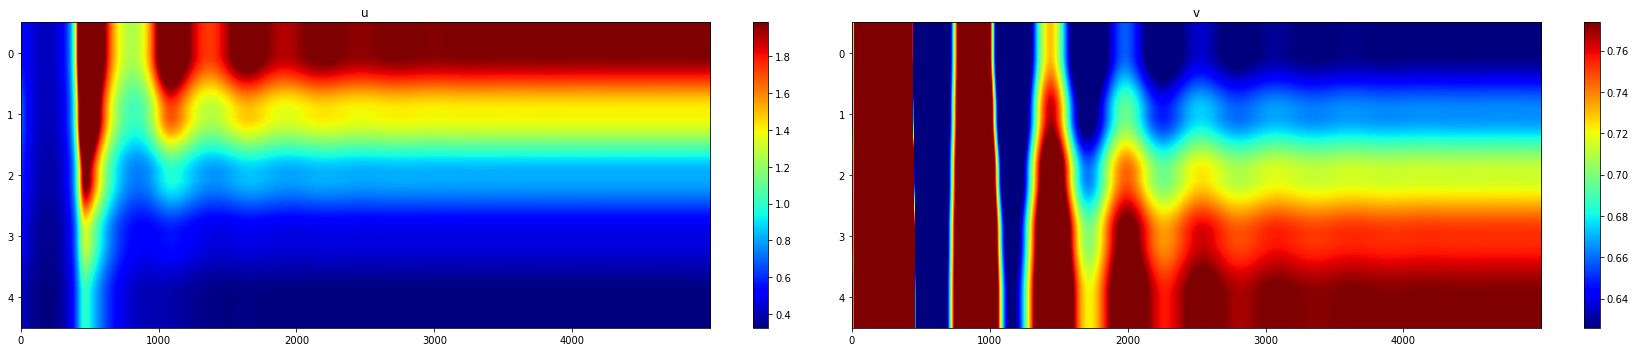

Pred:


<Figure size 432x288 with 0 Axes>

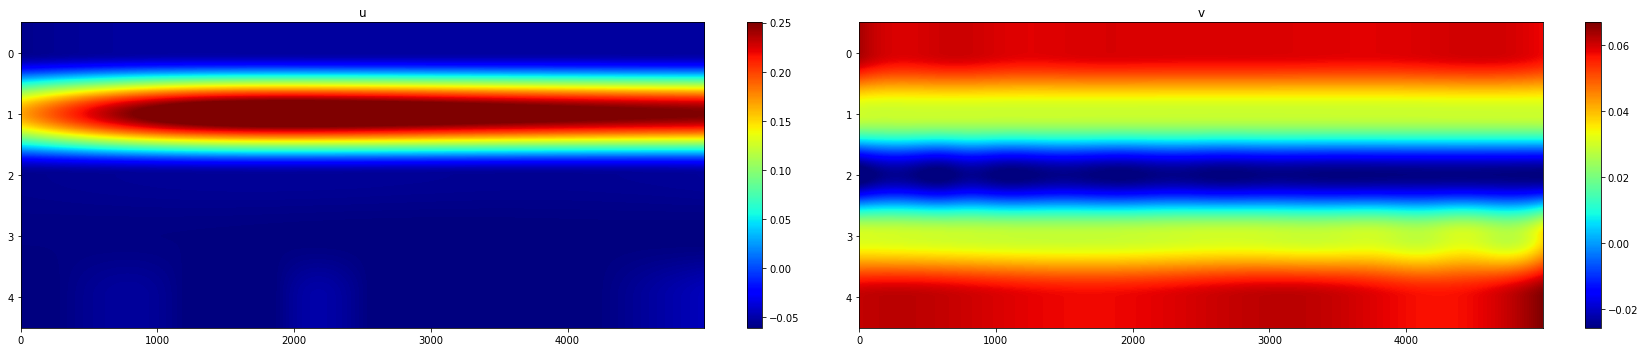

Diff:


<Figure size 432x288 with 0 Axes>

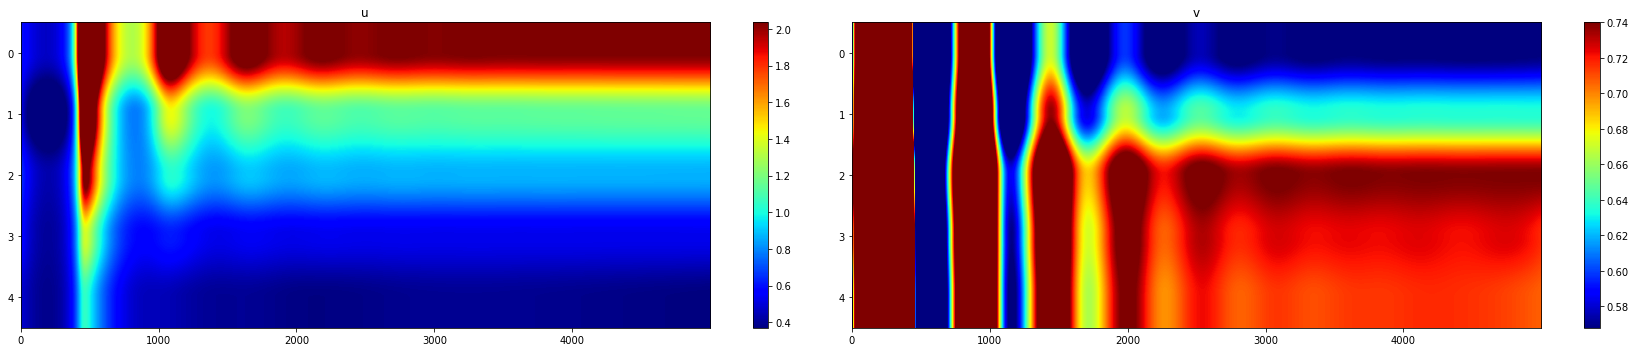

<Figure size 432x288 with 0 Axes>

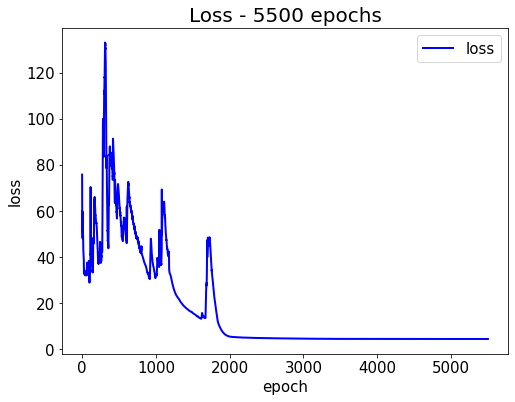

Epoch [05600/100000] Loss:4.561225 Loss_1:2.023597 Loss_2:1.713632 Loss_3:0.751372 Loss_4:0.072623 Lr:0.000641 Time:7.397794s (3.26min in total, 54.94min remains)
Epoch [05700/100000] Loss:4.561001 Loss_1:2.023582 Loss_2:1.713489 Loss_3:0.751421 Loss_4:0.072509 Lr:0.000637 Time:2.493213s (3.30min in total, 54.61min remains)
Epoch [05800/100000] Loss:4.560791 Loss_1:2.023566 Loss_2:1.713366 Loss_3:0.751457 Loss_4:0.072402 Lr:0.000633 Time:2.497877s (3.34min in total, 54.28min remains)


KeyboardInterrupt: ignored

In [26]:
# v2 - normal - 5 * 5000
# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

In [ ]:
# v2 - only truth - 100
# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# v2 - only truth - 5
# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

self.truth_length: 5000 of 5000 all 
truth shape: u: (5000, 5), v: (5000, 5)
config = {'T': 50.0, 'T_unit': 0.01, 'T_N': 5000, 'NN': 5, 'MM': 1, 'd1': 1, 'd2': 40, 'c1': 0.1, 'c2': 0.9, 'c_1': 1, 'c3': 1, 'l': 1, 'w': 1, 'u_0': array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ]), 'v_0': array([0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152]), 'y_0': array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152]), 'ub': 50.0, 'lb': 0.0, 'only_truth_flag': False, 'truth_rate': 1.0, 'truth_length': 5000}
loss: tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)
loss_list: [tensor(1.8706e-05, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(1.6938e-05, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)]
using cuda
epoch = 100000
epoch_step = 1
model_name = SimpleNetworkTuring
no

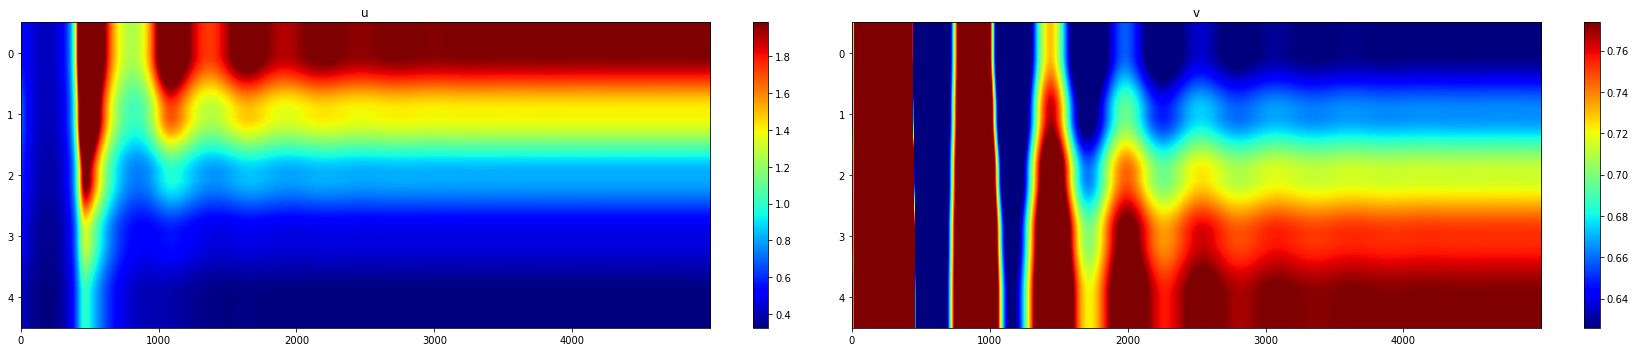

Pred:


<Figure size 432x288 with 0 Axes>

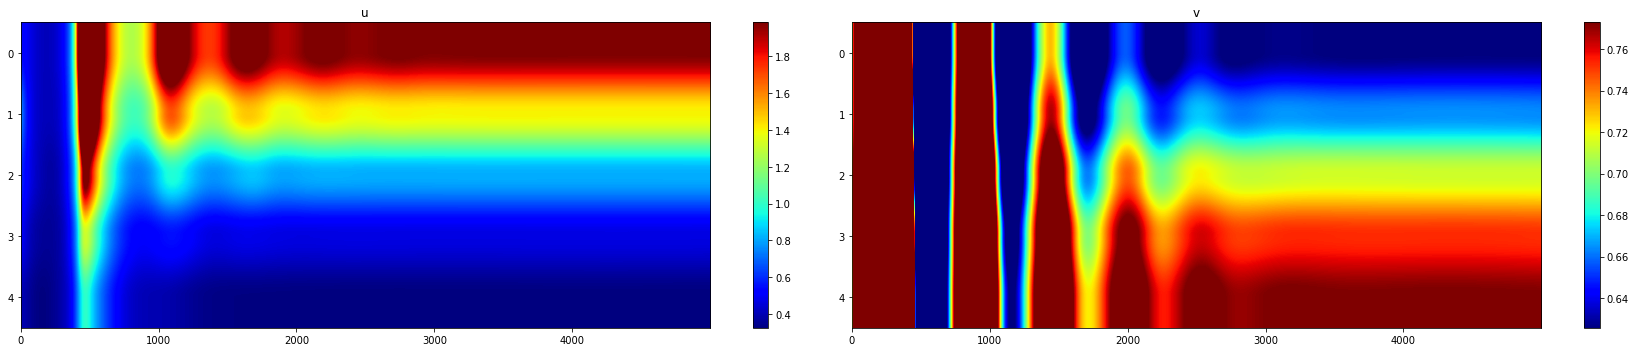

Diff:


<Figure size 432x288 with 0 Axes>

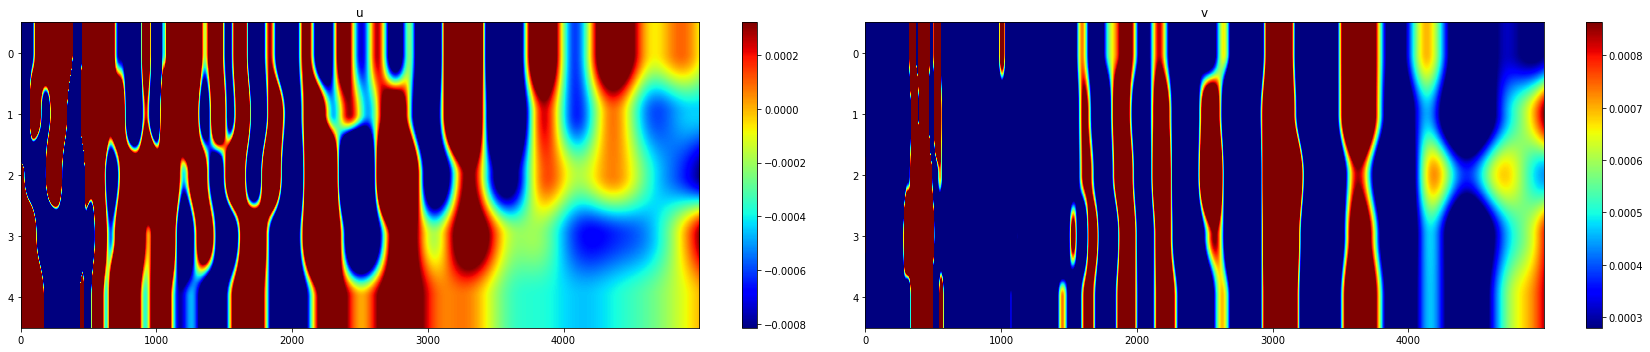

<Figure size 432x288 with 0 Axes>

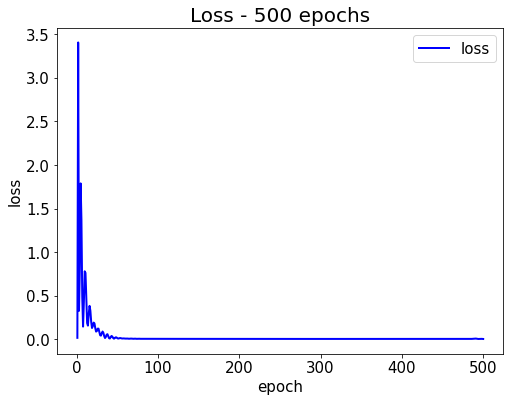

Epoch [00501/100000] Loss:0.004611 Loss_1:0.000065 Loss_2:0.004529 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:4.868946s (0.61min in total, 121.00min remains)
Epoch [00502/100000] Loss:0.005204 Loss_1:0.000065 Loss_2:0.005123 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:0.041989s (0.61min in total, 120.90min remains)
Epoch [00503/100000] Loss:0.005058 Loss_1:0.000065 Loss_2:0.004975 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:0.046972s (0.61min in total, 120.81min remains)
Epoch [00504/100000] Loss:0.004388 Loss_1:0.000065 Loss_2:0.004306 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:0.050129s (0.61min in total, 120.74min remains)
Epoch [00505/100000] Loss:0.003975 Loss_1:0.000065 Loss_2:0.003893 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:0.044641s (0.61min in total, 120.64min remains)
Epoch [00506/100000] Loss:0.004176 Loss_1:0.000065 Loss_2:0.004093 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000095 Time:0.067420s (0.61min in total, 120.62min remains)
Epoch [00507/100

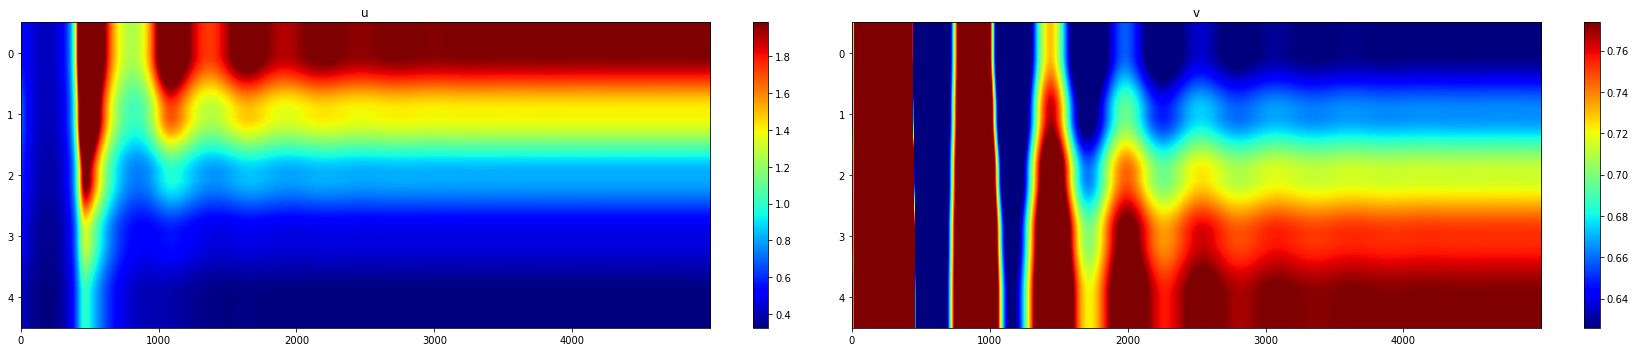

Pred:


<Figure size 432x288 with 0 Axes>

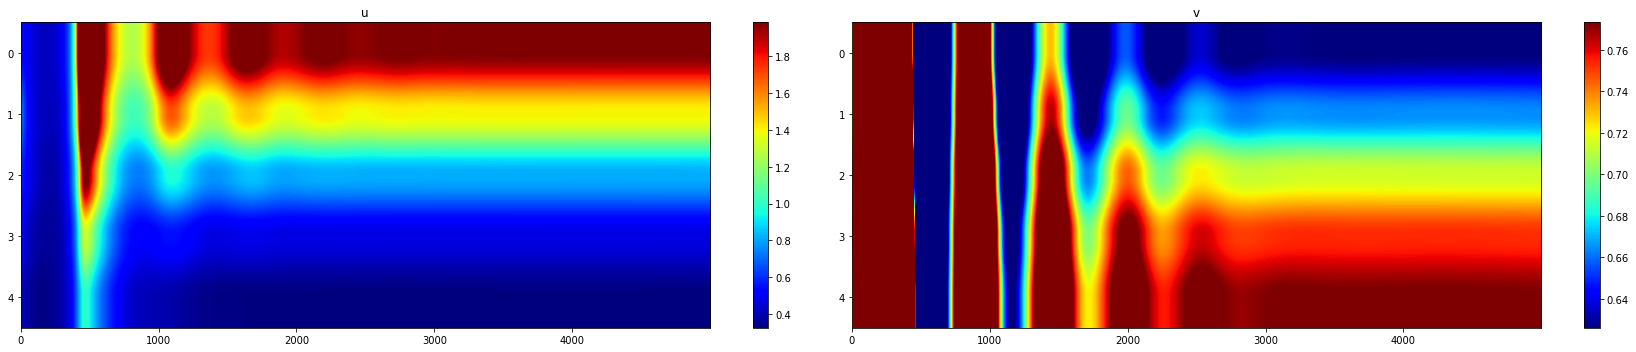

Diff:


<Figure size 432x288 with 0 Axes>

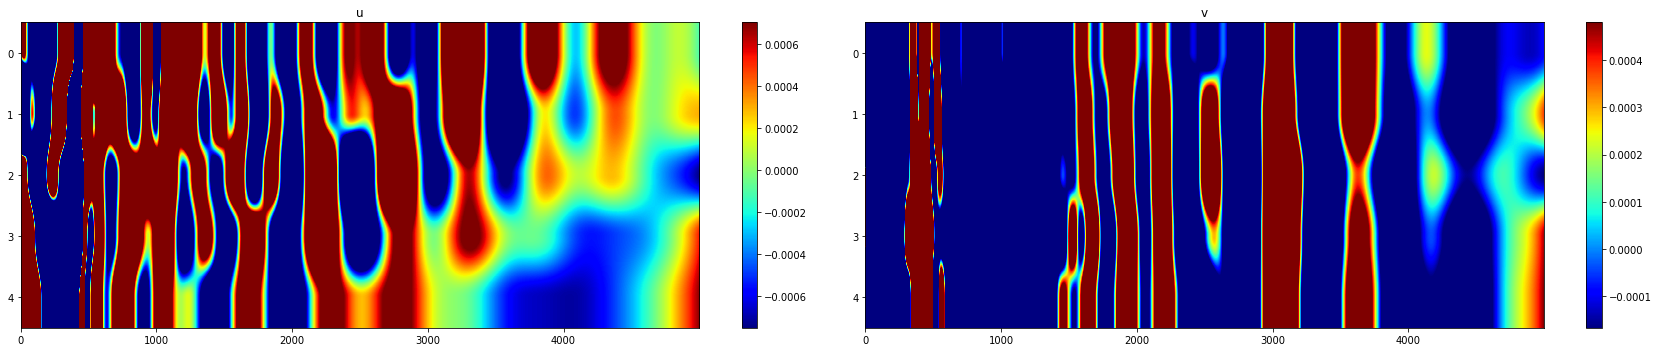

<Figure size 432x288 with 0 Axes>

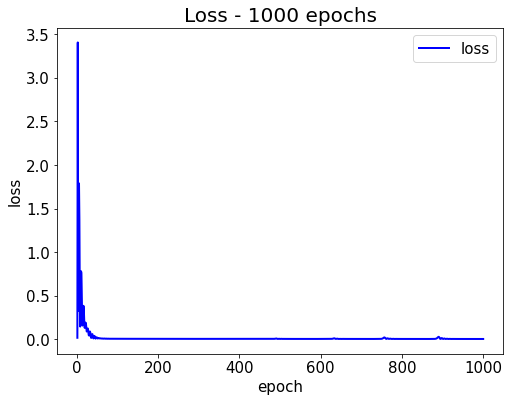

Epoch [01001/100000] Loss:0.003271 Loss_1:0.000097 Loss_2:0.003158 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:4.999034s (1.15min in total, 113.38min remains)
Epoch [01002/100000] Loss:0.003270 Loss_1:0.000097 Loss_2:0.003156 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:0.067623s (1.15min in total, 113.38min remains)
Epoch [01003/100000] Loss:0.003269 Loss_1:0.000097 Loss_2:0.003155 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:0.064219s (1.15min in total, 113.37min remains)
Epoch [01004/100000] Loss:0.003268 Loss_1:0.000097 Loss_2:0.003154 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:0.061692s (1.15min in total, 113.36min remains)
Epoch [01005/100000] Loss:0.003267 Loss_1:0.000097 Loss_2:0.003153 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:0.081804s (1.15min in total, 113.38min remains)
Epoch [01006/100000] Loss:0.003266 Loss_1:0.000097 Loss_2:0.003152 Loss_3:0.000017 Loss_4:0.000000 Lr:0.000091 Time:0.092014s (1.15min in total, 113.42min remains)
Epoch [01007/100

KeyboardInterrupt: ignored

In [110]:
# inherit only-truth version
args = Args
args.main_path = "/content/drive/My Drive/Workspace/PINN"
model_save_path = "/content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_100000_500_0.001_2022-06-18-05-39-20_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigTuring()
model = SimpleNetworkTuring(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
print("config = {}".format({item[0]: item[1] for item in model.config.__dict__.items() if item[0][0] != "_"}))
# test_turing(model, args, config, now_string, True)
loss, loss_list, _ = model.loss()
print("loss:", loss)
print("loss_list:", loss_list)
train_turing(model, args, config, now_string)

# model.eval()

# y = model.forward(model.x)
# u = y[:, :model.config.NN]
# v = y[:, model.config.NN:]

# print("[TEST] u:", u)

# u_gt = model.gt_u
# v_gt = model.gt_v

# print("u_gt - u:", u_gt - u)
# print("v_gt - v:", v_gt - v)
# u = u_gt
# v = v_gt
# u_t_collection, v_t_collection = [], []
# # print("cp1:", (torch.gradient(u[:,ii:ii+1].reshape([model.config.T_N])).shape))
# # print("cp2:", ((model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),)).shape)
# for ii in range(model.config.NN):
#   u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
#   v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
# u_t = torch.cat(u_t_collection, 1)
# v_t = torch.cat(v_t_collection, 1)

# print("[TEST] u_t:", u_t)

# print("u shape:", u.shape)
# print("v shape:", v.shape)

# print("last u:", u[-1,:])
# print("last v:", v[-1,:])


# u_from_left = torch.roll(u, 1, 1)
# u_from_left[:, :1] = u[:, :1]
# u_from_right = torch.roll(u, -1, 1)
# u_from_right[:, -1:] = u[:, -1:]

# print("u_from_left:", u_from_left)
# print("u_from_right:", u_from_right)

# v_from_left = torch.roll(v, 1, 1)
# v_from_left[:, :1] = v[:, :1]
# v_from_right = torch.roll(v, -1, 1)
# v_from_right[:, -1:] = v[:, -1:]

# print("v_from_left:", v_from_left)
# print("v_from_right:", v_from_right)

# u_diffusion = model.config.d1 * ((u_from_left + u_from_right - u * 2) / (model.config.l ** 2))
# v_diffusion = model.config.d2 * ((v_from_left + v_from_right - v * 2) / (model.config.l ** 2))

# print("[TEST] u_diffusion:", u_diffusion.cpu().detach().numpy())
# print("[TEST] v_diffusion:", v_diffusion.cpu().detach().numpy())

# print("last u_diffusion:", u_diffusion[-1,:])
# print("last v_diffusion:", v_diffusion[-1,:])

# # u_reaction = u * (model.config.alpha - model.config.beta * u - model.config.q / (u + model.config.b)) - model.config.c * u * v / (model.config.m * v + 1)
# # v_reaction = v * (-model.config.gamma + model.config.s * u / (model.config.m * v + 1))

# u_reaction = model.config.c1 - model.config.c_1 * u + model.config.c3 * (u ** 2) * v
# v_reaction = model.config.c2 - model.config.c3 * (u ** 2) * v

# u_t_target = u_diffusion + u_reaction
# v_t_target = v_diffusion + v_reaction

# print("u_t:", u_t)
# print("u_t_target:", u_t_target)

# print("v_t:", v_t)
# print("v_t_target:", v_t_target)

# f_u = u_t - u_t_target
# f_v = v_t - v_t_target

# print("f_u:", f_u)
# print("f_v:", f_v)
# print(model.loss_norm(u_t, u_t_target))
# print(model.loss_norm(v_t, v_t_target))
# print(model.loss_norm(torch.cat([u_t, v_t], 1), torch.cat([u_t_target, v_t_target], 1)))

# f_y = torch.cat([f_u, f_v], 1)

# zeros_2mn_D = torch.Tensor([[0.0] * (2 * model.config.NN * model.config.MM)] * model.config.T_N).to(model.device)

# loss_2 = model.loss_norm(f_y, zeros_2mn_D)
# print("loss_2:", loss_2)


# print("Ground truth")
# u_input, v_input = u.swapaxes(0, 1).cpu().detach().numpy(), v.swapaxes(0, 1).cpu().detach().numpy()
# # print("u_input:", u_input)
# # u_from_left = np.roll(u_input, 1, axis=1)
# # u_from_left[:, :1] = u_input[:, :1]
# # u_from_right = np.roll(u_input, -1, axis=1)
# # u_from_right[:, -1:] = u_input[:, -1:]
# u_from_top = np.roll(u_input, 1, axis=0)
# u_from_top[:1, :] = u_input[:1, :]
# u_from_bottom = np.roll(u_input, -1, axis=0)
# u_from_bottom[-1:, :] = u_input[-1:, :]
# # v_from_left = np.roll(v_input, 1, axis=1)
# # v_from_left[:, :1] = v_input[:, :1]
# # v_from_right = np.roll(v_input, -1, axis=1)
# # v_from_right[:, -1:] = v_input[:, -1:]
# v_from_top = np.roll(v_input, 1, axis=0)
# v_from_top[:1, :] = v_input[:1, :]
# v_from_bottom = np.roll(v_input, -1, axis=0)
# v_from_bottom[-1:, :] = v_input[-1:, :]
# u_diffusion = ((u_from_top + u_from_bottom - u_input * 2) / (model.config.w ** 2) ) * model.config.d1  # ((u_from_left + u_from_right - u_input * 2) / (l ** 2) + (u_from_top + u_from_bottom - u_input * 2) / (w ** 2)) * d1
# v_diffusion = ((v_from_top + v_from_bottom - v_input * 2) / (model.config.w ** 2) ) * model.config.d2  # ((v_from_left + v_from_right - v_input * 2) / (l ** 2) + (v_from_top + v_from_bottom - v_input * 2) / (w ** 2)) * d2

# print("[GT] u_diffusion:", u_diffusion.swapaxes(0, 1))
# print("[GT] v_diffusion:", v_diffusion.swapaxes(0, 1))

In [ ]:

# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - normal - only truth - 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - normal - 1.00 truth (300 point) - 2 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - normal - 0.0034 truth (1 point) - 2 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

self.truth_length: 300 of 300 all 
[[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5], [6, 6, 6, 6], [7, 7, 7, 7], [8, 8, 8, 8], [9, 9, 9, 9], [10, 10, 10, 10], [11, 11, 11, 11], [12, 12, 12, 12], [13, 13, 13, 13], [14, 14, 14, 14], [15, 15, 15, 15], [16, 16, 16, 16], [17, 17, 17, 17], [18, 18, 18, 18], [19, 19, 19, 19], [20, 20, 20, 20], [21, 21, 21, 21], [22, 22, 22, 22], [23, 23, 23, 23], [24, 24, 24, 24], [25, 25, 25, 25], [26, 26, 26, 26], [27, 27, 27, 27], [28, 28, 28, 28], [29, 29, 29, 29], [30, 30, 30, 30], [31, 31, 31, 31], [32, 32, 32, 32], [33, 33, 33, 33], [34, 34, 34, 34], [35, 35, 35, 35], [36, 36, 36, 36], [37, 37, 37, 37], [38, 38, 38, 38], [39, 39, 39, 39], [40, 40, 40, 40], [41, 41, 41, 41], [42, 42, 42, 42], [43, 43, 43, 43], [44, 44, 44, 44], [45, 45, 45, 45], [46, 46, 46, 46], [47, 47, 47, 47], [48, 48, 48, 48], [49, 49, 49, 49], [50, 50, 50, 50], [51, 51, 51, 51], [52, 52, 52, 52], [53, 53, 53, 53], [54, 54, 54, 54], [55, 55, 55, 5

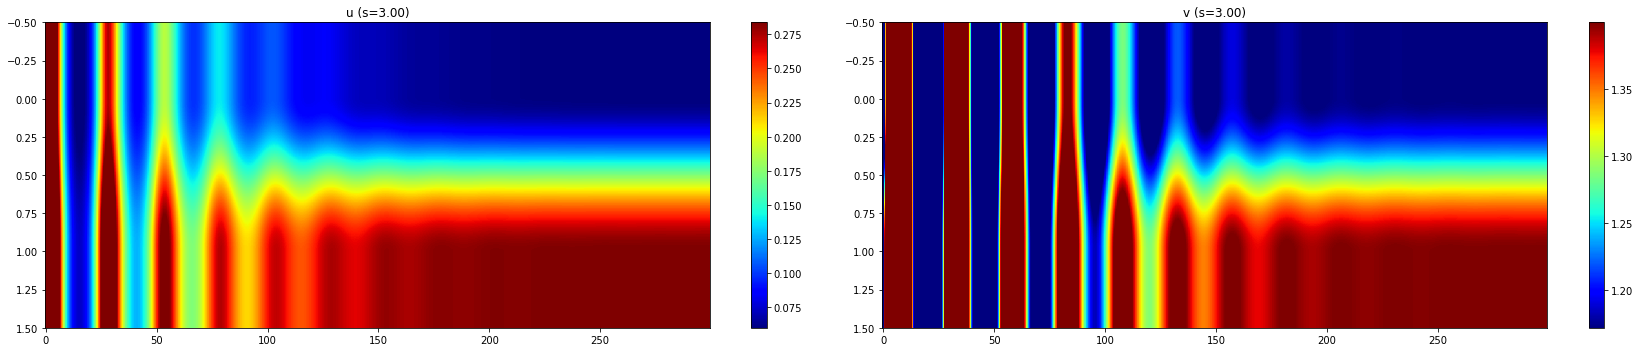

Pred:


<Figure size 432x288 with 0 Axes>

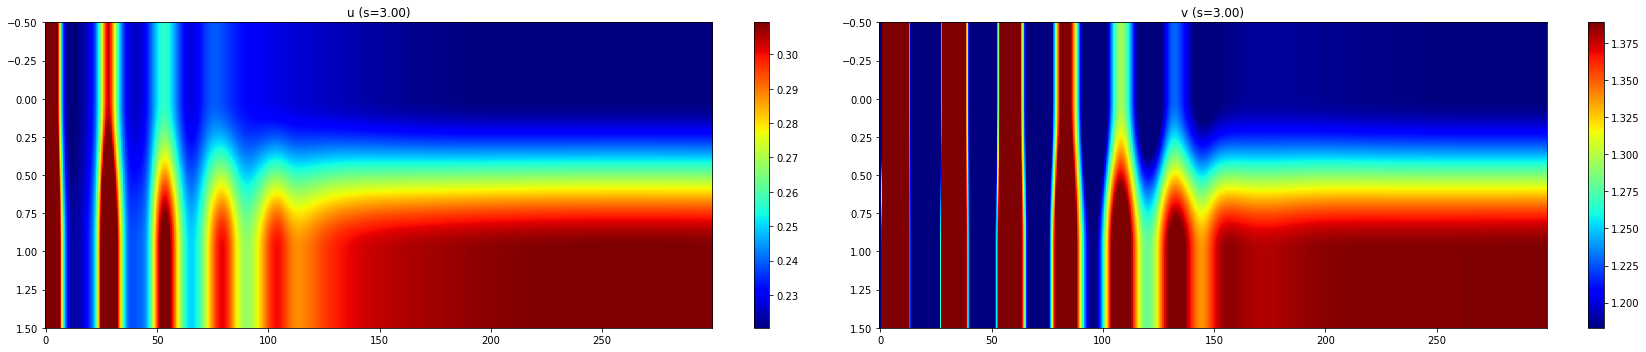

Diff:


<Figure size 432x288 with 0 Axes>

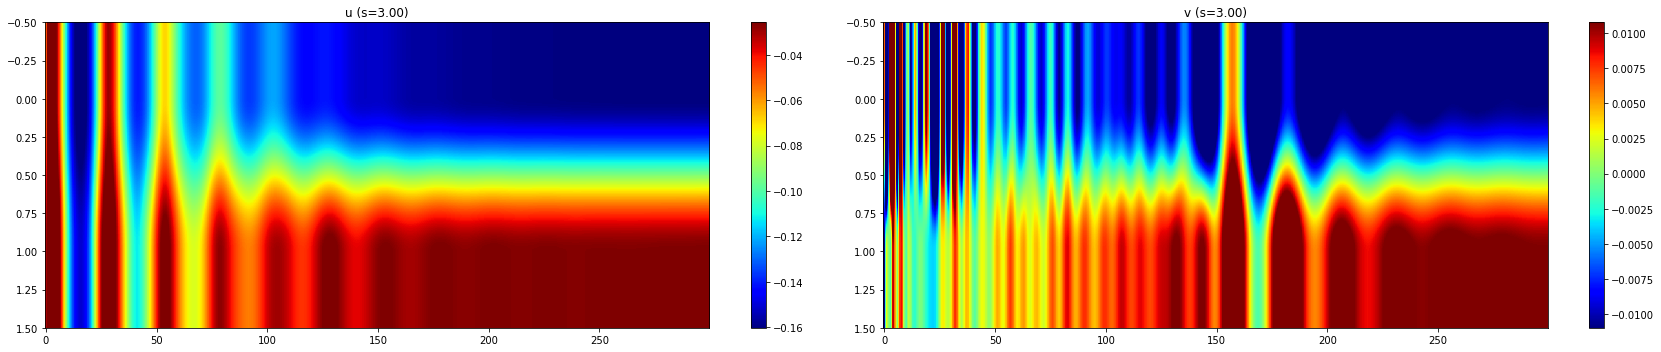

<Figure size 432x288 with 0 Axes>

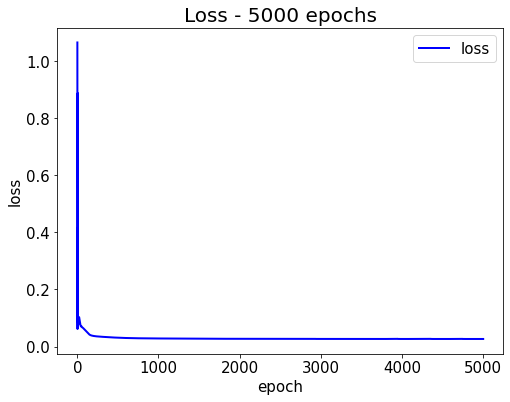

Epoch [06000/100000] Loss:0.026434 Loss_1:0.011296 Loss_2:0.022168 Loss_3:0.012921 Loss_4:0.000000 Lr:0.000625 Time:15.634787s (1.24min in total, 19.50min remains)


KeyboardInterrupt: ignored

In [ ]:
# debug here

args = Args
args.main_path = "/content/drive/My Drive/Workspace/PINN"
model_save_path = "/content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigTuring()
model = SimpleNetworkTuring(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
print("config = {}".format({item[0]: item[1] for item in model.config.__dict__.items() if item[0][0] != "_"}))
# test_turing(model, args, config, now_string, True)
loss, loss_list = model.loss()
print("loss:", loss)
print("loss_list:", loss_list)
train_turing(model, args, config, now_string)
# model.eval()

# y = model.forward(model.x)
# u = y[:, :2]
# v = y[:, 2:]

# u_gt = model.gt_u
# v_gt = model.gt_v

# # print("u_gt - u:", u_gt - u)
# # print("v_gt - v:", v_gt - v)

# u_t_collection, v_t_collection = [], []
# for ii in range(model.config.NN):
#   u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
#   v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
# u_t = torch.cat(u_t_collection, 1)
# v_t = torch.cat(v_t_collection, 1)

# u_from_left = torch.roll(u, 1, 1)
# u_from_left[:, :1] = u[:, :1]
# u_from_right = torch.roll(u, -1, 1)
# u_from_right[:, -1:] = u[:, -1:]

# v_from_left = torch.roll(v, 1, 1)
# v_from_left[:, :1] = v[:, :1]
# v_from_right = torch.roll(v, -1, 1)
# v_from_right[:, -1:] = v[:, -1:]

# u_diffusion = model.config.d1 * ((u_from_left + u_from_right - u * 2) / (model.config.l ** 2))
# v_diffusion = model.config.d2 * ((v_from_left + v_from_right - v * 2) / (model.config.l ** 2))

# u_reaction = u * (model.config.alpha - model.config.beta * u - model.config.q / (u + model.config.b)) - model.config.c * u * v / (model.config.m * v + 1)
# v_reaction = v * (-model.config.gamma + model.config.s * u / (model.config.m * v + 1))

# u_t_target = u_diffusion + u_reaction
# v_t_target = v_diffusion + v_reaction

# print("u_t:", u_t)
# print("u_t_target:", u_t_target)

# print("v_t:", v_t)
# print("v_t_target:", v_t_target)

# f_u = u_t - u_t_target
# f_v = v_t - v_t_target

# print("f_u:", f_u)
# print("f_v:", f_v)




In [ ]:
# Turing - only truth 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - only truth 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - only truth 100 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.